# Action Space Analysis for AWS DeepRacer

## Overview

This notebook provides comprehensive analysis tools for AWS DeepRacer action space data. The analysis helps understand model behavior, action distribution patterns, and training effectiveness through interactive visualizations and statistical insights.

**Key Features:**
- Action space visualization and mapping
- Comprehensive histograms and distribution analysis
- Episode-by-episode performance tracking
- Polar coordinate analysis for steering patterns
- Track visualization with action overlays

## Prerequisites

- AWS DeepRacer training data (SIM trace logs)
- DeepRacer-Analysis library installed
- AWS credentials configured (if accessing S3 data)

## Data Sources

This notebook works with simulation trace logs from:
- Local DeepRacer training environments
- AWS DeepRacer console training
- Custom training setups

## Analysis Workflow

1. **Setup & Configuration** - Import libraries and configure AWS access
2. **Data Loading** - Load track information and training logs  
3. **Action Space Extraction** - Parse and categorize action space data
4. **Visualization** - Generate comprehensive visual analysis
5. **Performance Analysis** - Analyze training effectiveness per action

---

## Getting Started

Run the cells below in sequence to perform the analysis.

## 1. Environment Setup

### Installation Requirements

If running in AWS SageMaker or similar cloud environments, install required dependencies first:

In [1]:
# Make sure you have the required pre-reqs

# import sys

# !{sys.executable} -m pip install --upgrade -r requirements.txt

### Import Libraries

Import all required packages for data analysis and visualization:

In [2]:
# Core data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import os
import warnings

# DeepRacer specific libraries
from deepracer.tracks import TrackIO, Track
from deepracer.logs import (
    SimulationLogsIO as slio, 
    PlottingUtils as pu,
    AnalysisUtils as au, 
    DeepRacerLog, 
    S3FileHandler
)

# Configure plotting
%matplotlib inline
plt.style.use('default')

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. AWS Authentication

Configure AWS credentials for accessing training data stored in S3. Choose one of the following methods:

**Option 1:** IAM Role (recommended for EC2/SageMaker)
- Ensure your instance has the appropriate IAM role with S3 access

**Option 2:** AWS CLI Configuration
- Use `aws configure` command to set up credentials
- Supported by DeepRacer-for-Cloud's `dr-start-loganalysis`

**Option 3:** Environment Variables
- Set credentials directly in notebook (uncomment section below)

In [3]:
# Option 3: Manual credential configuration
# Uncomment and fill in your AWS credentials if needed

# os.environ["AWS_DEFAULT_REGION"] = "us-east-1"  # Your AWS region
# os.environ["AWS_ACCESS_KEY_ID"] = ""            # Your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = ""        # Your secret key  
# os.environ["AWS_SESSION_TOKEN"] = ""            # Session token (if using temporary credentials)

print("AWS credentials configured")

AWS credentials configured


## 3. Track Configuration

### Available Tracks

Load track data for visualization and analysis. The track files contain waypoint information used for plotting the racing line and boundaries.

**Note:** Track .npy files are community-contributed visualizations and may not be 100% accurate to official track specifications.

In [12]:
track_io = TrackIO(base_path="/Users/bartmlynarkiewicz/msc/notebooks/deepracer-research/deepracer-analysis/tracks")

available_tracks = track_io.get_tracks()
print("=" * 40)
for i, track_name in enumerate(available_tracks, 1):
    print(f"{i:2}. {track_name}")
print("=" * 40)

 1. 2022_april_open.npy
 2. 2022_april_open_ccw.npy
 3. 2022_april_open_cw.npy
 4. 2022_april_pro.npy
 5. 2022_april_pro_ccw.npy
 6. 2022_april_pro_cw.npy
 7. 2022_august_open.npy
 8. 2022_august_open_ccw.npy
 9. 2022_august_open_cw.npy
10. 2022_august_pro.npy
11. 2022_august_pro_ccw.npy
12. 2022_august_pro_cw.npy
13. 2022_july_open.npy
14. 2022_july_pro.npy
15. 2022_july_pro_ccw.npy
16. 2022_july_pro_cw.npy
17. 2022_june_open.npy
18. 2022_june_open_ccw.npy
19. 2022_june_open_cw.npy
20. 2022_june_pro.npy
21. 2022_june_pro_ccw.npy
22. 2022_june_pro_cw.npy
23. 2022_march_open.npy
24. 2022_march_open_ccw.npy
25. 2022_march_open_cw.npy
26. 2022_march_pro.npy
27. 2022_march_pro_ccw.npy
28. 2022_march_pro_cw.npy
29. 2022_may_open.npy
30. 2022_may_open_ccw.npy
31. 2022_may_open_cw.npy
32. 2022_may_pro.npy
33. 2022_may_pro_ccw.npy
34. 2022_may_pro_cw.npy
35. 2022_october_open.npy
36. 2022_october_open_ccw.npy
37. 2022_october_open_cw.npy
38. 2022_october_pro.npy
39. 2022_october_pro_ccw.npy
40

### Load Selected Track

Choose a track from the list above and load its geometric data:

Loaded 86 waypoints
✓ Successfully loaded track: 2024_reinvent_champ_cw
  - Center line points: 86
  - Outer border points: 86
  - Inner border points: 86


<Figure size 1200x800 with 0 Axes>

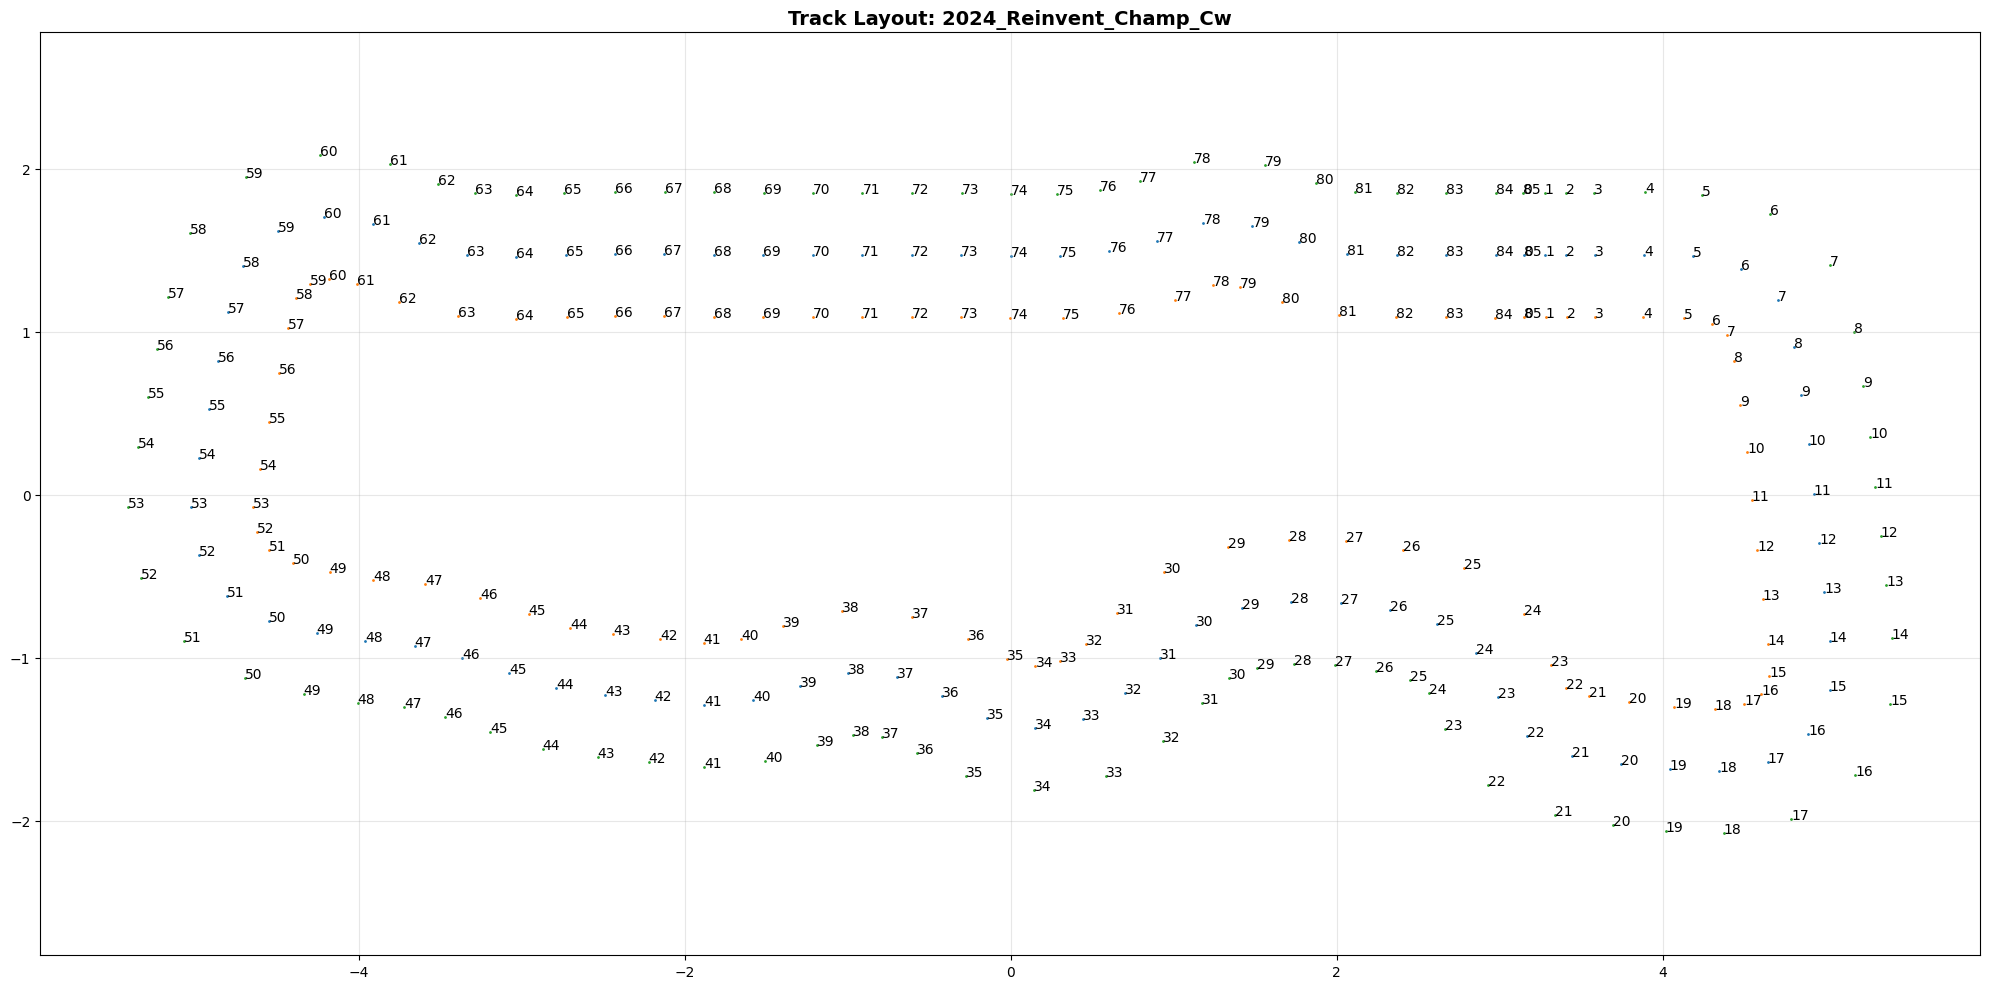

In [ ]:
TRACK_NAME = "2024_reinvent_champ_cw"

try:
    track = track_io.load_track(TRACK_NAME)
    
    center_line = track.center_line
    outer_border = track.outer_border  
    inner_border = track.inner_border
    
    print(f"✓ Successfully loaded track: {TRACK_NAME}")
    print(f"  - Center line points: {len(center_line)}")
    print(f"  - Outer border points: {len(outer_border)}")
    print(f"  - Inner border points: {len(inner_border)}")
    
    plt.figure(figsize=(12, 8))
    pu.plot_trackpoints(track)
    plt.title(f"Track Layout: {TRACK_NAME.title()}", fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error loading track '{TRACK_NAME}': {e}")
    print("Please check the track name and try again.")

## 4. Training Data Configuration

### Data Source Setup

Configure the source of your training data. The system supports multiple data sources:

**Local Training (DeepRacer-for-Cloud):**
- Default bucket: `bucket`
- Default endpoint: `http://minio:9000`
- Profile: `minio`

**AWS Console Training:**
- S3 bucket containing your model data
- Standard AWS S3 endpoint (None)
- AWS credentials profile

For detailed configuration examples, see the [DeepRacer Utils documentation](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md).

In [17]:
PREFIX='8e4c1bcd/Sat, 02 Aug 2025 20:24:37 GMT'
BUCKET='deepracer-thunder-compute-8e4c1bcd-20250802-010723-af09074f'
PROFILE='default'
S3_ENDPOINT_URL=None


print("Data Source Configuration:")
print("=" * 30)
print(f"Bucket:       {BUCKET}")
print(f"Prefix:       {PREFIX}")  
print(f"Profile:      {PROFILE if PROFILE else 'Default'}")
print(f"Endpoint:     {S3_ENDPOINT_URL if S3_ENDPOINT_URL else 'AWS S3'}")
print("=" * 30)

Data Source Configuration:
Bucket:       deepracer-thunder-compute-8e4c1bcd-20250802-010723-af09074f
Prefix:       8e4c1bcd/Sat, 02 Aug 2025 20:24:37 GMT
Profile:      default
Endpoint:     AWS S3


In [18]:
print("Loading training data...")

try:
    file_handler = S3FileHandler(
        bucket=BUCKET, 
        prefix=PREFIX, 
        profile=PROFILE, 
        s3_endpoint_url=S3_ENDPOINT_URL
    )
    
    log = DeepRacerLog(filehandler=file_handler)
    log.load_training_trace()
    
    print("Training data loaded successfully")
    
    print("\nModel Information:")
    print("-" * 40)
    
    try:
        agent_info = log.agent_and_network()
        if agent_info:
            pprint(agent_info)
        
        print("\nHyperparameters:")
        hyperparams = log.hyperparameters()
        if hyperparams:
            pprint(hyperparams)
            
        print("\nAction Space:")
        action_space = log.action_space()
        if action_space:
            pprint(action_space)
            
    except Exception as info_error:
        print(f"⚠️  Model metadata not available: {info_error}")
    
    # Load dataframe and calculate episodes per iteration
    df = log.dataframe()
    print(f"\n✓ Loaded {len(df)} training steps across {df['episode'].nunique()} episodes")
    
    # Calculate episodes per iteration
    try:
        num_workers = df['worker'].nunique() if 'worker' in df.columns else 1
        if num_workers > 1:
            print(f"✓ Detected {num_workers} parallel workers")
            EPISODES_PER_ITERATION = int(hyperparams['num_episodes_between_training'] / num_workers)
        else:
            EPISODES_PER_ITERATION = int(hyperparams['num_episodes_between_training'])
        
        print(f"✓ Episodes per iteration: {EPISODES_PER_ITERATION}")
        
    except (KeyError, TypeError):
        print("⚠️  Could not determine episodes per iteration, using default of 20")
        EPISODES_PER_ITERATION = 20

except Exception as e:
    print(f"❌ Error loading training data: {e}")
    print("Please check your configuration and try again.")

Loading training data...
Training data loaded successfully

Model Information:
----------------------------------------
{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['SECTOR_LIDAR', 'STEREO_CAMERAS'],
 'simapp_version': '5'}

Hyperparameters:
{'batch_size': 64,
 'beta_entropy': 0.03,
 'discount_factor': 0.98,
 'e_greedy_value': 1.0,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0002,
 'num_episodes_between_training': 8,
 'num_epochs': 6,
 'stack_size': 1,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 100000}

Action Space:
{'speed': {'high': 2.5, 'low': 0.5},
 'steering_angle': {'high': 30.0, 'low': -30.0}}

✓ Loaded 47376 training steps across 592 episodes
✓ Episodes per iteration: 8


## 5. Training Data Analysis

### Understanding the Data Structure

The training logs contain detailed information about each simulation step. Each log entry includes:

| Field | Description |
|-------|-------------|
| `episode` | Episode number |
| `steps` | Step number within episode |
| `x`, `y` | Vehicle position coordinates |
| `yaw` | Vehicle heading direction |
| `steering_angle` | Steering decision from action space |
| `speed` | Throttle decision from action space |
| `action` | Action index from discrete action space |
| `reward` | Reward value for this step |
| `all_wheels_on_track` | Boolean: vehicle within track boundaries |
| `progress` | Lap completion percentage |
| `closest_waypoint` | Nearest track waypoint |
| `track_length` | Total track length |
| `timestamp` | Step timestamp |

### Training Progress Overview

Analyze overall training performance and convergence patterns:

In [19]:
simulation_agg = au.simulation_agg(df)

try: 
    if 'worker' in df.columns and df['worker'].nunique() > 1:
        print("✓ Multiple workers detected - grouping by unique episode")
        simulation_agg = au.simulation_agg(df, secondgroup="unique_episode")
    else:
        print("✓ Single worker training detected")
except Exception as e:
    print(f"⚠️  Worker detection failed: {e}")
    print("Proceeding with standard aggregation")

new reward not found, using reward as its values
✓ Single worker training detected


Number of episodes =  591
Number of iterations =  73


<Figure size 1500x1000 with 0 Axes>

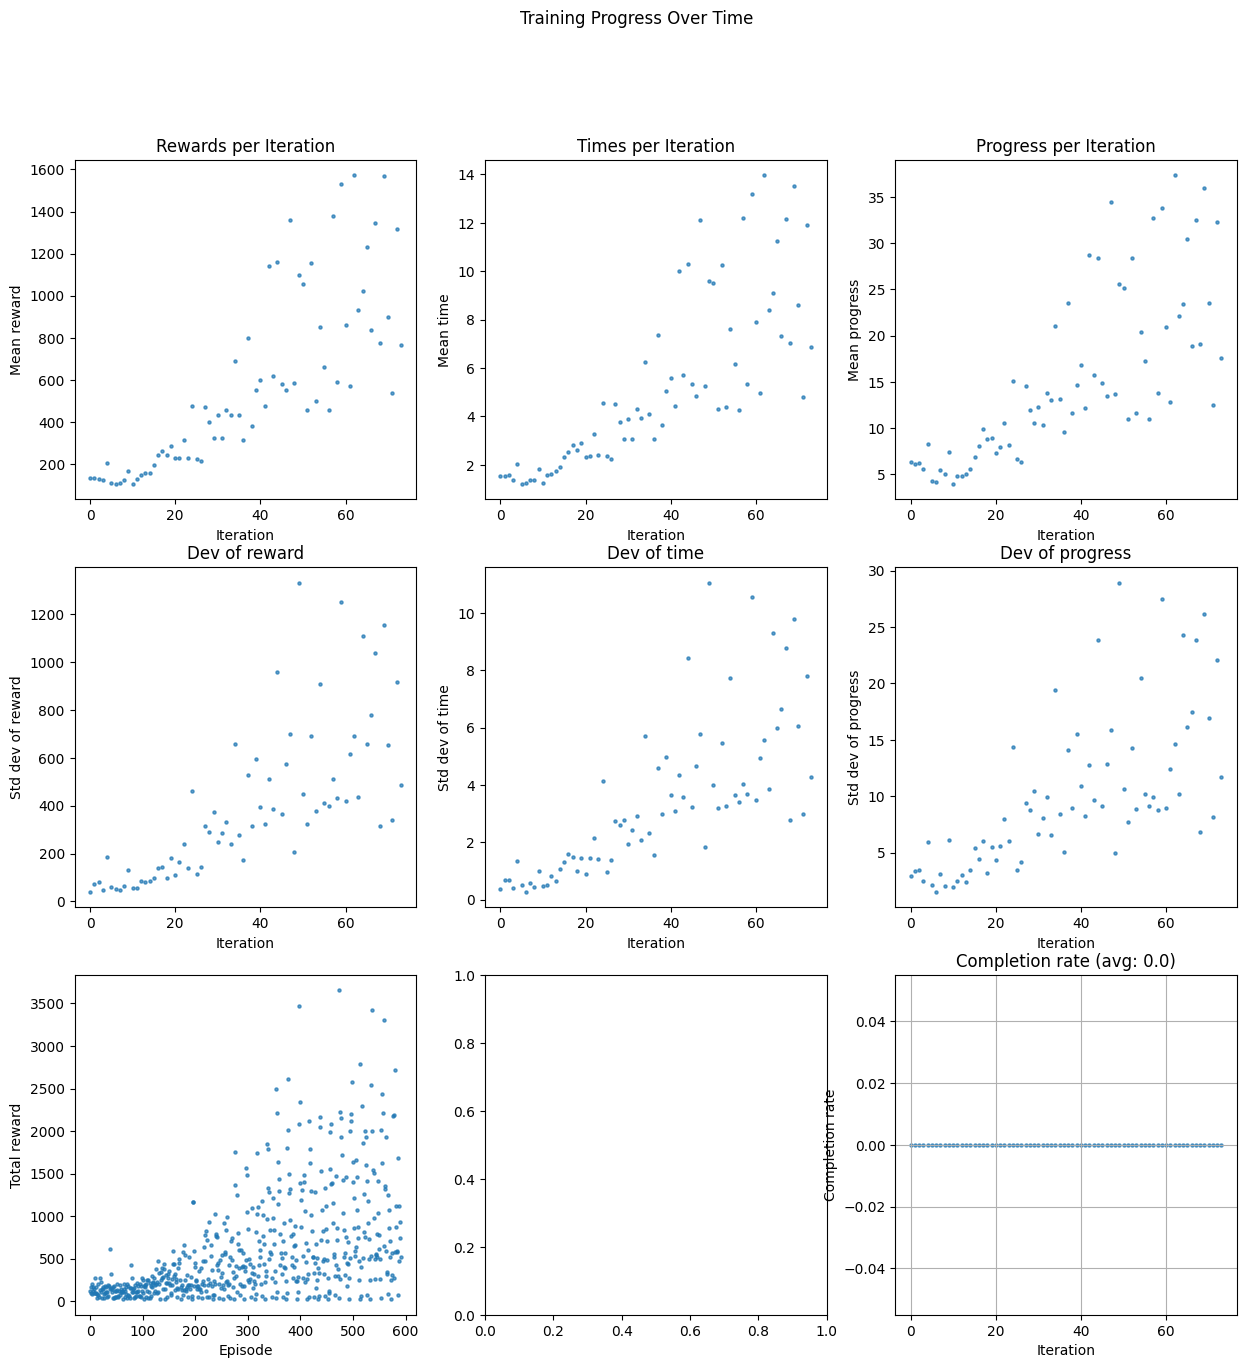

<Figure size 640x480 with 0 Axes>

Training Summary:
- Total episodes: 592
- Max progress achieved: 80.9%
- Average episode reward: 570.75
- Episodes completed (100%): 0


In [20]:
plt.figure(figsize=(15, 10))

au.analyze_training_progress(simulation_agg, title='Training Progress Over Time')

plt.tight_layout()
plt.show()

print(f"Training Summary:")
print(f"- Total episodes: {len(simulation_agg)}")
print(f"- Max progress achieved: {simulation_agg['progress'].max():.1f}%")
print(f"- Average episode reward: {simulation_agg['reward'].mean():.2f}")
print(f"- Episodes completed (100%): {len(simulation_agg[simulation_agg['progress'] >= 100])}")

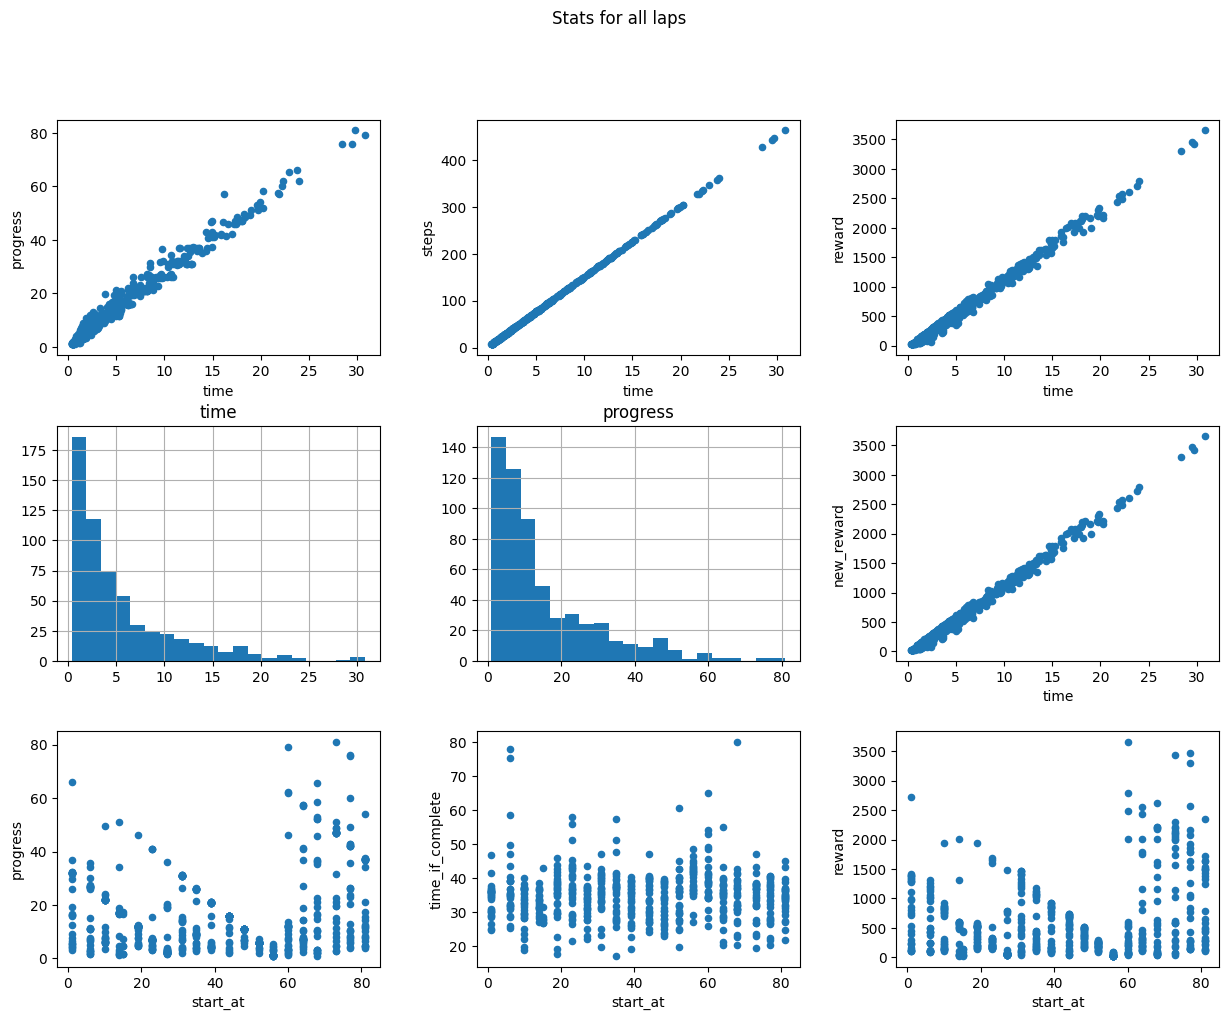

<Figure size 640x480 with 0 Axes>

In [21]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

In [22]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

No complete laps yet.


In [23]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete


In [24]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
537,67,537,447.0,73,80.928780,29.740,19.672341,3427.156519,0.687329,3427.156519,36.748360,4234.780875,5th,0
474,59,474,463.0,60,79.204309,30.830,20.349749,3653.308761,0.678771,3653.308761,38.924650,4612.512663,5th,0
398,49,398,443.0,77,75.933831,29.476,18.417627,3465.062254,0.659838,3465.062254,38.818007,4563.265433,4th,0
558,69,558,427.0,77,75.897284,28.402,18.512328,3306.654971,0.671909,3306.654971,37.421629,4356.750069,5th,0
580,72,580,358.0,1,66.038968,23.795,15.712514,2717.686014,0.717453,2717.686014,36.031756,4115.276324,5th,0


In [25]:
# View information for a couple last episodes
simulation_agg.tail()

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
587,73,587,68.0,31,10.472861,4.475,2.896489,470.956135,0.807491,470.956135,42.729490,4496.919615,5th,0
588,73,588,149.0,35,25.981708,9.900,6.367965,1123.915423,0.677423,1123.915423,38.103731,4325.794993,5th,0
589,73,589,124.0,39,20.951129,8.187,5.116440,928.556458,0.635563,928.556458,39.076653,4432.011535,5th,0
590,73,590,98.0,44,16.010149,6.489,3.798437,738.748947,0.575736,738.748947,40.530540,4614.253940,5th,0
591,73,591,65.0,48,10.897410,4.278,2.563777,517.414074,0.600784,517.414074,39.257036,4748.046480,5th,0


In [26]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==320]

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,delta_time,delta_dist,new_reward
13729,320,1.0,3.288593,1.471307,0.564062,30.000000,0.575118,-1,0.000000,False,...,25.106791,1954.530,prepare,0.0,40,0,320,0.000,0.000000,0.000000
13730,320,2.0,3.288315,1.471350,0.603360,-19.720832,0.500000,-1,8.357277,False,...,25.106791,1954.643,in_progress,0.0,40,0,320,0.113,0.000281,8.357277
13731,320,3.0,3.300681,1.466939,-0.454869,11.109037,1.589441,-1,9.781455,False,...,25.106791,1954.689,in_progress,0.0,40,0,320,0.046,0.013129,9.781455
13732,320,4.0,3.312686,1.466012,-0.629907,-4.029087,0.500000,-1,9.699098,False,...,25.106791,1954.738,in_progress,0.0,40,0,320,0.049,0.012040,9.699098
13733,320,5.0,3.329484,1.468644,0.113131,-30.000000,1.677875,-1,9.073878,False,...,25.106791,1954.840,in_progress,0.0,40,0,320,0.102,0.017003,9.073878
13734,320,6.0,3.391870,1.452384,-3.813134,19.584375,0.500000,-1,9.021840,False,...,25.106791,1954.900,in_progress,0.0,40,0,320,0.060,0.064470,9.021840
13735,320,7.0,3.427284,1.435360,-7.449997,30.000000,0.517872,-1,8.925768,False,...,25.106791,1954.946,in_progress,0.0,40,0,320,0.046,0.039294,8.925768
13736,320,8.0,3.459125,1.424756,-9.014834,30.000000,0.500000,-1,8.861430,False,...,25.106791,1955.040,in_progress,0.0,40,0,320,0.094,0.033560,8.861430
13737,320,9.0,3.517266,1.422357,-7.441825,30.000000,0.500000,-1,8.864686,False,...,25.106791,1955.094,in_progress,0.0,40,0,320,0.054,0.058191,8.864686
13738,320,10.0,3.550871,1.433503,-3.728099,14.132954,0.500000,-1,9.516650,False,...,25.106791,1955.151,in_progress,0.0,40,0,320,0.057,0.035405,9.516650


## 6. Action Space Analysis

### Extract and Process Action Space Data

Parse the discrete action space from training logs to understand the model's available actions:

In [27]:
# Extract action space configuration
print("Extracting action space from training data...")

# Determine angle normalization (radians vs degrees)
steering_max = df['steering_angle'].max()
angle_normalization = 57.2958 if steering_max < 2 else 1  # Convert radians to degrees if needed

class ActionSpaceItem:
    """Represents a single action in the discrete action space"""
    def __init__(self, index, steering_angle, speed):
        self.index = int(index)
        self.steering_angle = round(steering_angle * angle_normalization, 2)
        self.speed = round(speed, 2)
        self.relative_throttle = 0.0
        self.color = [0, 0, 0]  # RGB color for visualization

# Calculate action space statistics
max_throttle = df['speed'].max()
action_stats = df[df['steps'] != 0].groupby(['action'], as_index=False)[['steering_angle', 'speed']].median()

# Create action space list
action_space_list = []
for _, row in action_stats.iterrows():
    action_idx = int(row['action'])
    action_item = ActionSpaceItem(action_idx, row['steering_angle'], row['speed'])
    action_item.relative_throttle = row['speed'] / max_throttle
    
    # Assign color based on steering (red=left, green=straight, blue=right)
    steering_norm = action_item.steering_angle
    red_component = max(0, steering_norm) / 30 * 0.8
    green_component = (30 - abs(steering_norm)) / 30 * 0.6  
    blue_component = max(0, -steering_norm) / 30 * 0.8
    
    action_item.color = [red_component, green_component, blue_component]
    action_space_list.append(action_item)

# Sort by action index
action_space_list.sort(key=lambda x: x.index)

# Display action space summary
print(f"✓ Extracted {len(action_space_list)} discrete actions")
print(f"✓ Steering range: {min(a.steering_angle for a in action_space_list):.1f}° to {max(a.steering_angle for a in action_space_list):.1f}°")
print(f"✓ Speed range: {min(a.speed for a in action_space_list):.1f} to {max(a.speed for a in action_space_list):.1f} m/s")

# Calculate track plotting boundaries
track_frame_margin = 50
track_bounds = {
    'x_min': min(outer_border[:, 0]) - track_frame_margin,
    'x_max': max(outer_border[:, 0]) + track_frame_margin,
    'y_min': min(outer_border[:, 1]) - track_frame_margin,
    'y_max': max(outer_border[:, 1]) + track_frame_margin
}

# Action space plotting boundaries  
action_bounds = {
    'steering_min': round(df['steering_angle'].min() * angle_normalization, 2),
    'steering_max': round(df['steering_angle'].max() * angle_normalization, 2),
    'speed_min': round(df['speed'].min(), 2),
    'speed_max': round(df['speed'].max(), 2)
}

print("\nAction Space Details:")
print("=" * 50)
print(f"{'Index':<6} {'Steering (°)':<12} {'Speed (m/s)':<12}")
print("-" * 50)
for action in action_space_list:
    print(f"{action.index:<6} {action.steering_angle:<12} {action.speed:<12}")
print("=" * 50)

Extracting action space from training data...
✓ Extracted 1 discrete actions
✓ Steering range: -12.3° to -12.3°
✓ Speed range: 0.5 to 0.5 m/s

Action Space Details:
Index  Steering (°) Speed (m/s) 
--------------------------------------------------
-1     -12.35       0.5         


### Visualization Functions

Define helper functions for creating comprehensive action space visualizations:

In [28]:
def plot_action_index_map(action_list, title="Action Index Map"):
    """
    Create a scatter plot showing action space distribution with indices
    
    Args:
        action_list: List of ActionSpaceItem objects
        title: Plot title
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot each action as a colored circle with size proportional to throttle
    for action in action_list:
        scatter = ax.scatter(
            action.steering_angle, 
            action.speed,
            c=[action.color],
            s=1200 * action.relative_throttle,
            alpha=0.85,
            edgecolors='black',
            linewidth=1
        )
        
        # Add action index as text
        ax.annotate(
            str(action.index),
            (action.steering_angle, action.speed),
            ha='center', va='center',
            fontsize=12, fontweight='bold',
            color='white'
        )
    
    ax.set_xlabel('Steering Angle (degrees)', fontsize=12)
    ax.set_ylabel('Speed (m/s)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-35, 35)
    ax.set_ylim(0, max(a.speed for a in action_list) * 1.1)
    
    # Add legend
    ax.text(0.02, 0.98, 
            'Circle size = throttle intensity\n'
            'Colors: Red=Left, Green=Straight, Blue=Right',
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()


def plot_combined_histograms(df_episode, title_suffix=""):
    """
    Create 2x2 combined histogram plots for steering and speed analysis
    
    Args:
        df_episode: Pandas DataFrame with episode data
        title_suffix: Additional text for plot title
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Steering histogram (top left)
    ax1.hist(df_episode['steering_angle'] * angle_normalization, bins=60, 
             alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Steering Angle (degrees)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Steering Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Polar plot (top right)
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(df_episode['steering_angle'], df_episode['speed'], 
               bins=(90, 23), range=[[-1.57, 1.57], [0, action_bounds['speed_max']]])
    ax2.set_title('Polar Steering vs Speed')
    
    # 2D histogram (bottom left)  
    ax3.hist2d(df_episode['steering_angle'] * angle_normalization, df_episode['speed'],
               bins=(63, 56), range=[[-31, 31], [0, action_bounds['speed_max']]])
    ax3.set_xlabel('Steering Angle (degrees)')
    ax3.set_ylabel('Speed (m/s)')
    ax3.set_title('2D Action Distribution')
    
    # Speed histogram (bottom right)
    ax4.hist(df_episode['speed'], bins=50, orientation="horizontal",
             alpha=0.7, color='lightcoral', edgecolor='black')
    ax4.set_ylabel('Speed (m/s)')
    ax4.set_xlabel('Frequency')
    ax4.set_title('Speed Distribution')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Action Analysis {title_suffix}', fontsize=16, fontweight='bold')
    plt.tight_layout()


def plot_polar_histogram(df_episode, title_suffix=""):
    """
    Create large polar histogram for steering analysis
    
    Args:
        df_episode: Pandas DataFrame with episode data  
        title_suffix: Additional text for plot title
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    
    # Create polar histogram
    hist = ax.hist2d(
        df_episode['steering_angle'], 
        df_episode['speed'],
        bins=(90, 25), 
        range=[[-1.57, 1.57], [0, action_bounds['speed_max']]]
    )
    
    ax.set_title(f'Polar Action Distribution {title_suffix}', 
                fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()


def plot_episode_trajectory(df_episode, episode_num, style='color'):
    """
    Plot vehicle trajectory on track with action visualization
    
    Args:
        df_episode: Pandas DataFrame with single episode data
        episode_num: Episode number for title
        style: 'color' for colored dots, 'red' for red dots
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_aspect('equal')
    
    # Plot track boundaries
    pu.print_border(ax, track, color="lightgray")
    
    if style == 'color':
        # Plot colored trajectory points
        for _, step in df_episode.iterrows():
            x, y = step['x'], step['y']
            action_idx = int(step['action'])
            
            # Find corresponding action for color and size
            action_item = next((a for a in action_space_list if a.index == action_idx), None)
            if action_item:
                color = action_item.color
                size = (action_item.relative_throttle ** 2) * 50
            else:
                color = [0.5, 0.5, 0.5]
                size = 20
                
            ax.scatter(x, y, color=color, s=size, alpha=0.75, edgecolors='black', linewidth=0.5)
    else:
        # Plot simple red dots
        ax.scatter(df_episode['x'], df_episode['y'], color='red', s=30, alpha=0.7)
    
    ax.set_xlim(track_bounds['x_min'], track_bounds['x_max'])
    ax.set_ylim(track_bounds['y_min'], track_bounds['y_max'])
    ax.set_title(f'Episode {episode_num} Trajectory', fontsize=14, fontweight='bold')
    
    if style == 'color':
        ax.text(0.02, 0.02,
                'Dot size ∝ throttle\nColors: Red=Left, Green=Straight, Blue=Right',
                transform=ax.transAxes,
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()

print("✓ Visualization functions defined successfully")

✓ Visualization functions defined successfully


## 7. Action Space Visualization

### Interactive Action Map

Visualize the complete action space with indices, relative speeds, and steering directions:

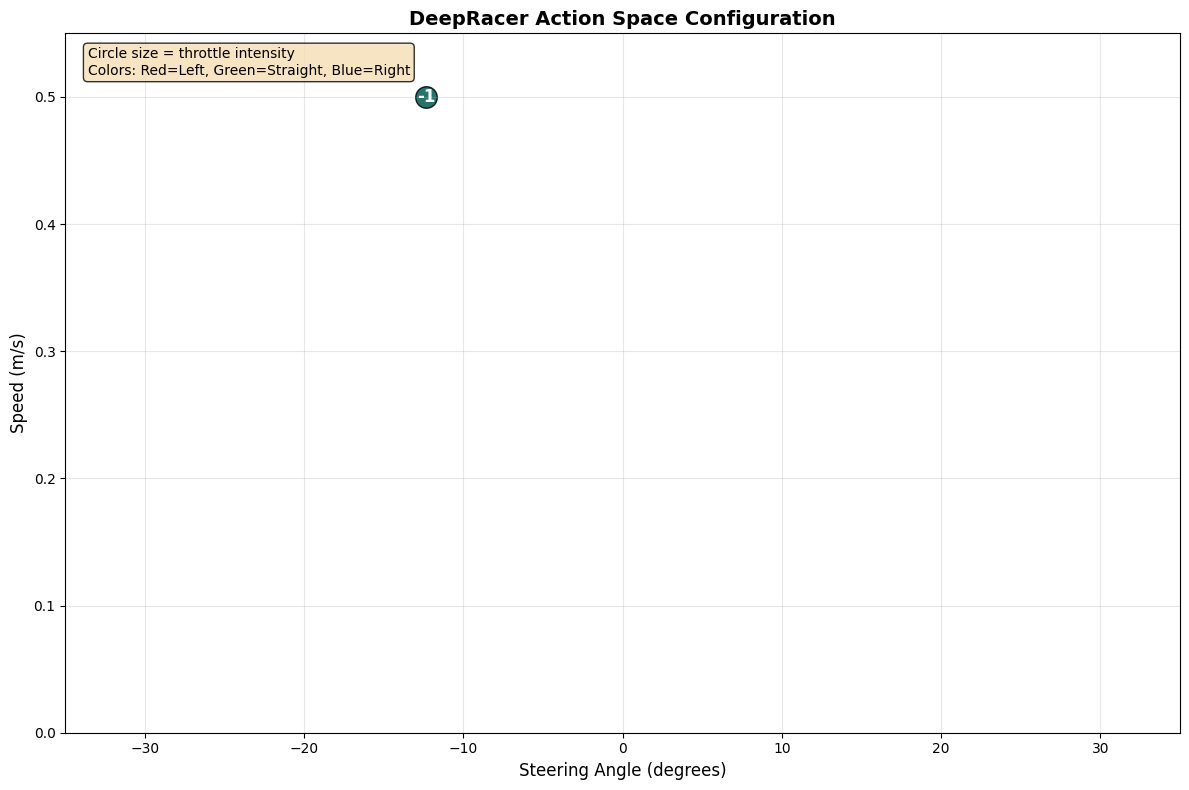

Action space characteristics:
- Total actions: 1
- Steering diversity: 1 unique angles
- Speed diversity: 1 unique speeds
- Most aggressive turn: 12.3°
- Speed variation: 1.0x


In [29]:
# Generate action index map
plot_action_index_map(action_space_list, "DeepRacer Action Space Configuration")
plt.show()

print("Action space characteristics:")
print(f"- Total actions: {len(action_space_list)}")
print(f"- Steering diversity: {len(set(a.steering_angle for a in action_space_list))} unique angles")
print(f"- Speed diversity: {len(set(a.speed for a in action_space_list))} unique speeds")
print(f"- Most aggressive turn: {max(abs(a.steering_angle) for a in action_space_list):.1f}°")
print(f"- Speed variation: {(max(a.speed for a in action_space_list) / min(a.speed for a in action_space_list)):.1f}x")

## 8. Overall Training Analysis

### Track Performance Visualization

Analyze action usage patterns across the entire training dataset:

Generating track performance heatmap...


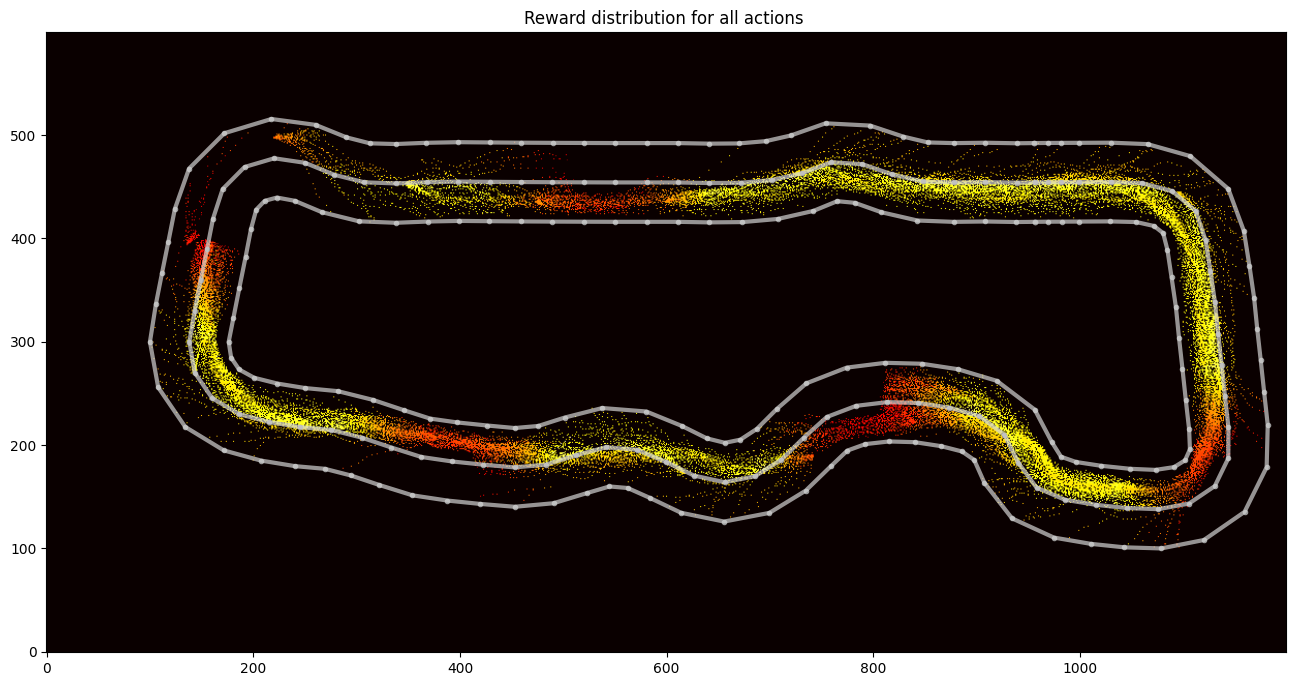

Track analysis complete. Areas with higher rewards (warmer colors) indicate better performance.


<Figure size 640x480 with 0 Axes>

In [32]:
print("Generating track performance heatmap...")

plt.figure(figsize=(16, 12))
track_plot = pu.plot_track(df, track, value_field="reward")

print("Track analysis complete. Areas with higher rewards (warmer colors) indicate better performance.")

Creating action distribution analysis...


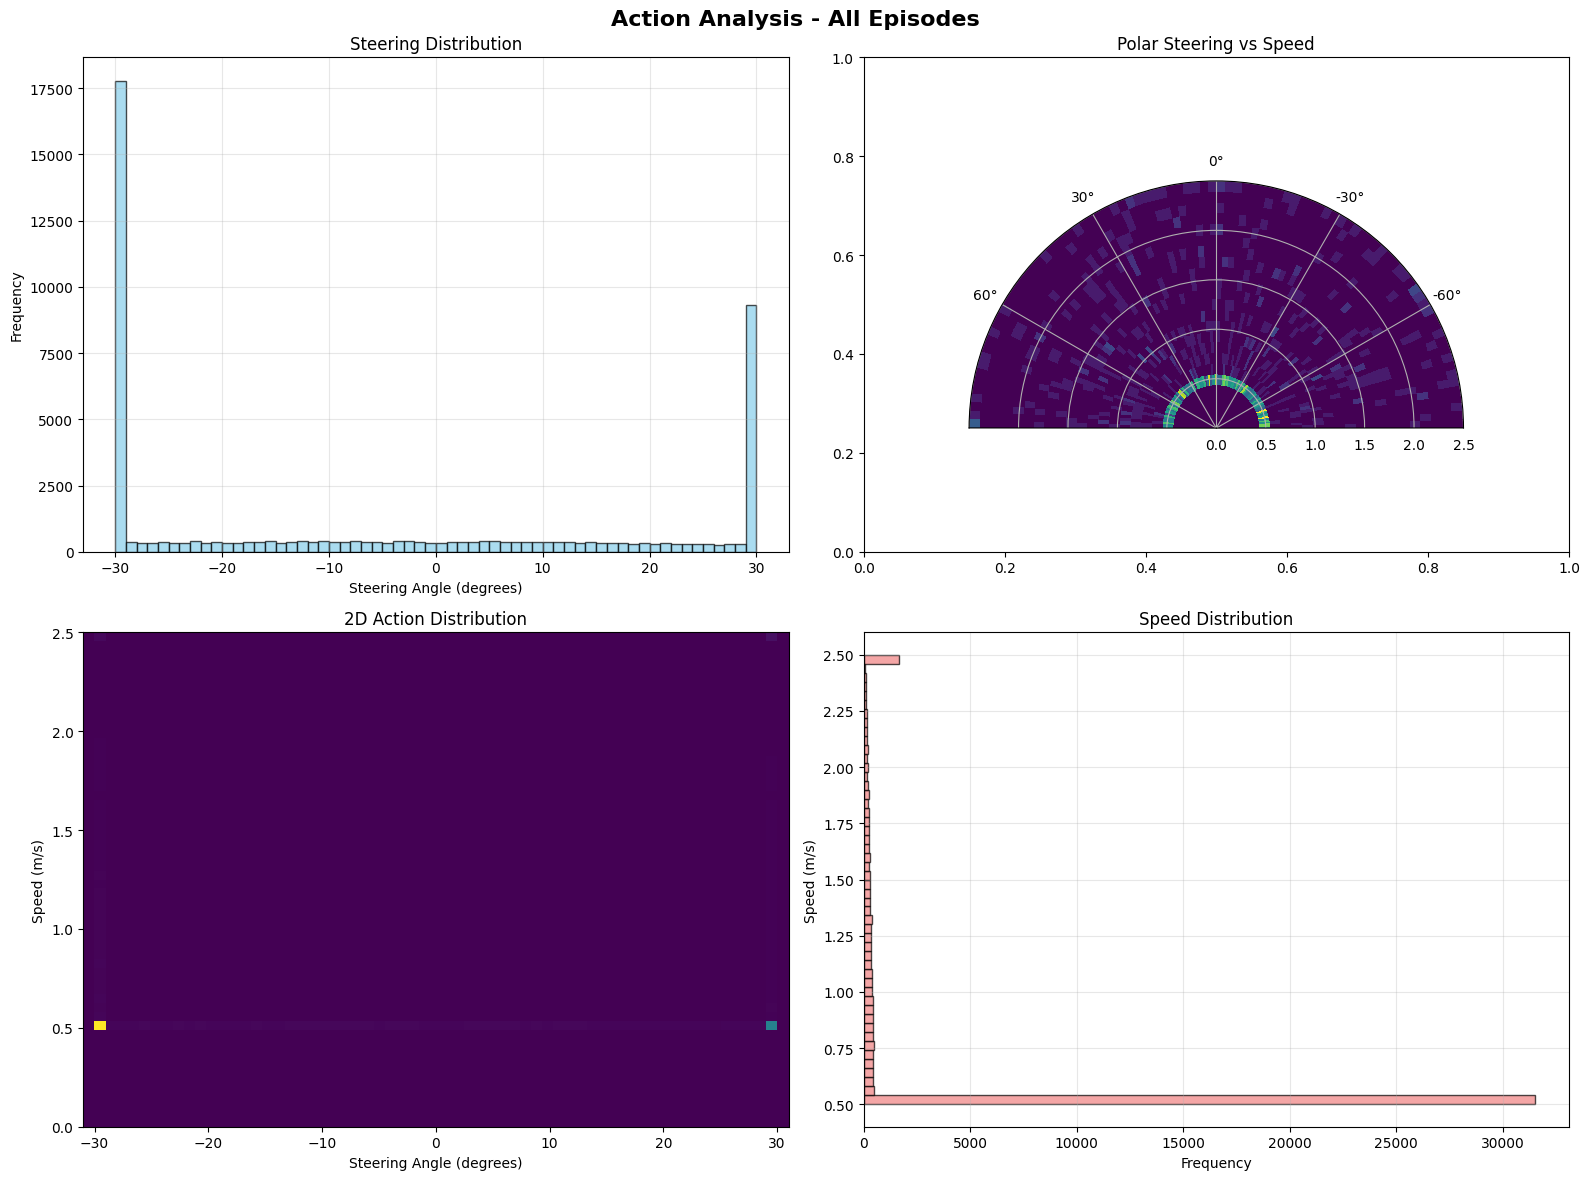

Histogram analysis shows the distribution of steering and speed choices across all training.


In [33]:
# Generate comprehensive histograms for all episodes
print("Creating action distribution analysis...")

plot_combined_histograms(df, "- All Episodes")
plt.show()

print("Histogram analysis shows the distribution of steering and speed choices across all training.")

Creating polar action distribution...


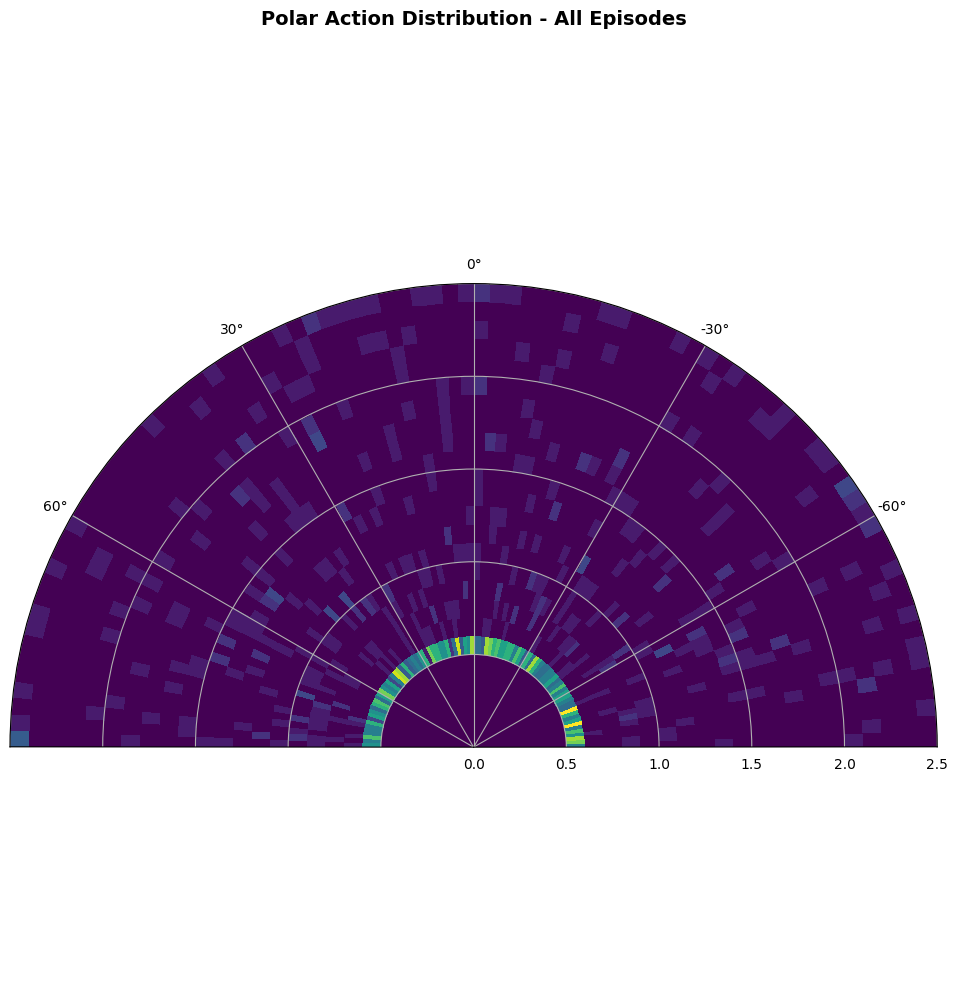

Polar plot reveals steering patterns: center = straight ahead, radius = speed intensity.


In [34]:
print("Creating polar action distribution...")

plot_polar_histogram(df, "- All Episodes")
plt.show()

print("Polar plot reveals steering patterns: center = straight ahead, radius = speed intensity.")

## 9. Iteration-Specific Analysis

### Focus on Recent Training Performance

Analyze action patterns from a specific training iteration to understand recent model behavior:

In [35]:
max_iteration = df['iteration'].max() if 'iteration' in df.columns else 10
selected_iteration = max(1, max_iteration - 5)  # Analyze recent but not latest iteration

print(f"Available iterations: 1 to {max_iteration}")
print(f"Selected iteration for analysis: {selected_iteration}")
print(f"Episodes in this iteration: {(selected_iteration-1)*EPISODES_PER_ITERATION + 1} to {selected_iteration*EPISODES_PER_ITERATION}")

Available iterations: 1 to 73
Selected iteration for analysis: 68
Episodes in this iteration: 537 to 544


Plotting episode trajectories for iteration 68...


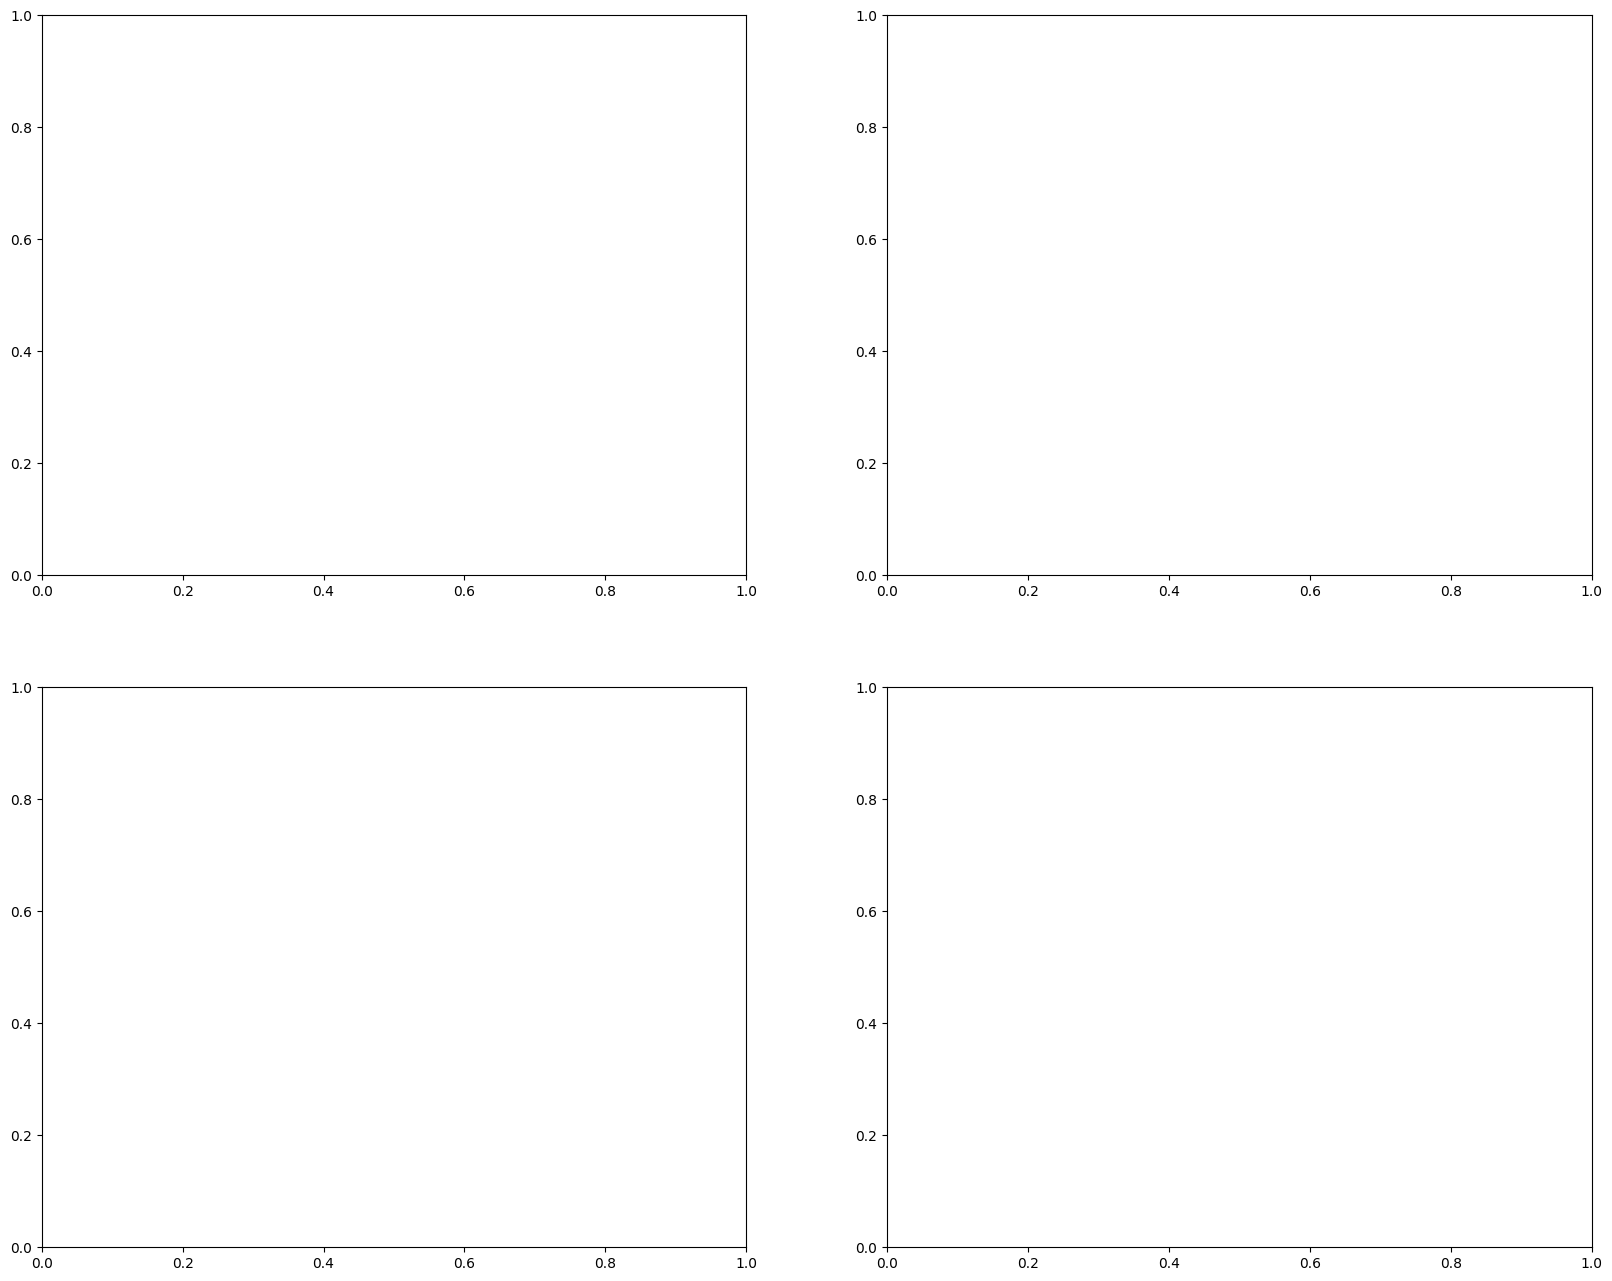

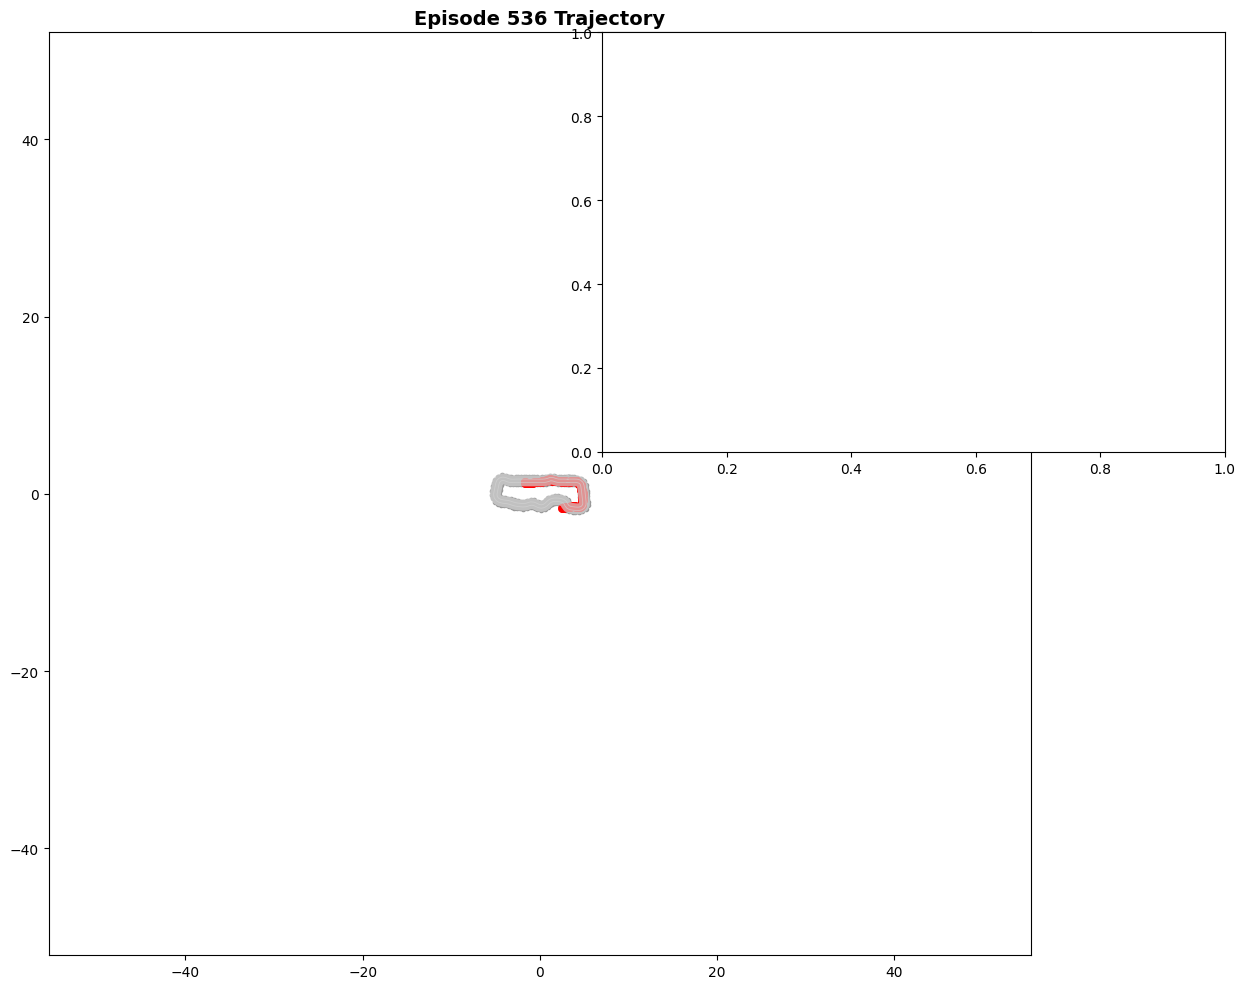

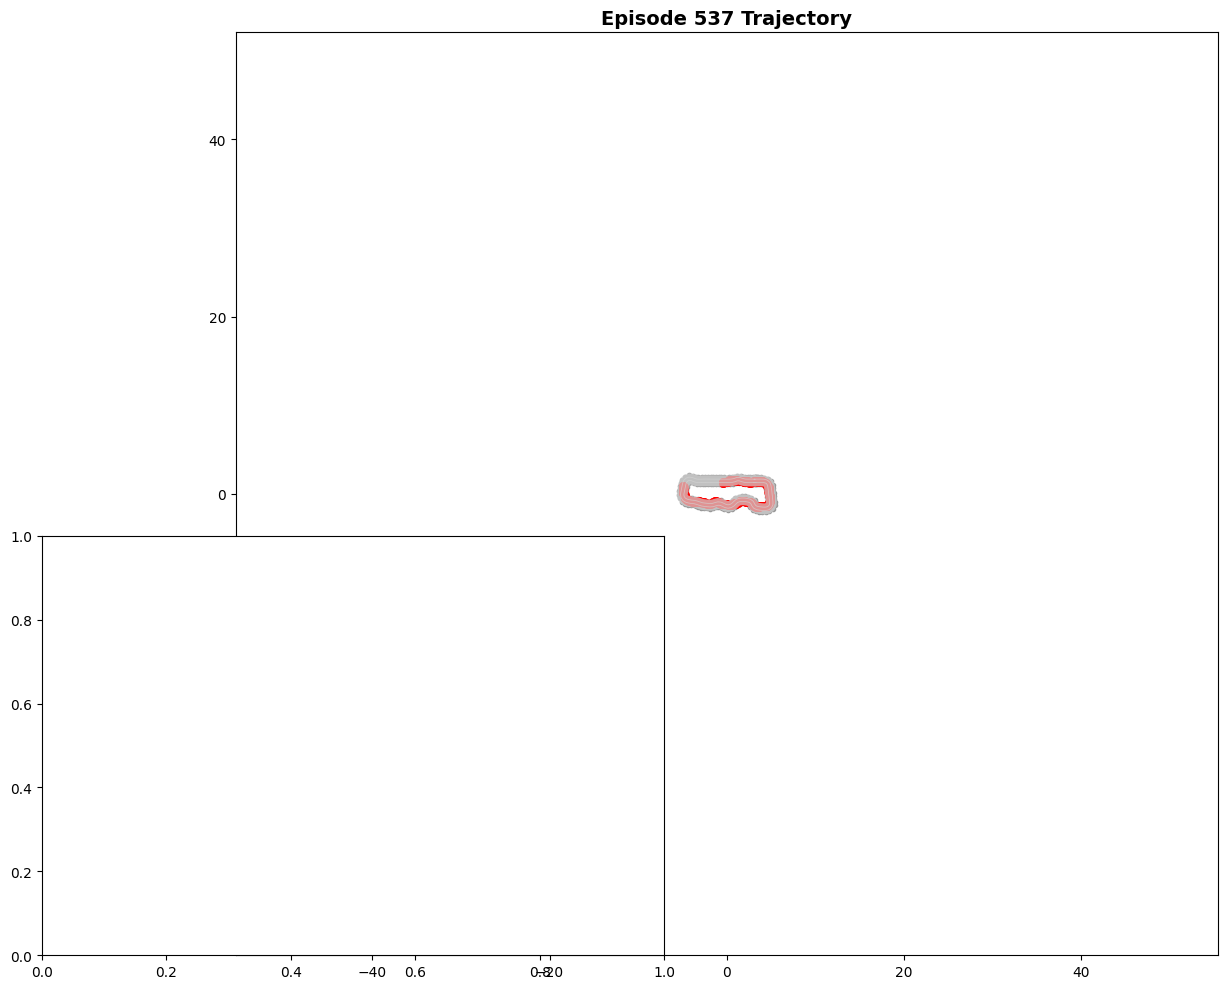

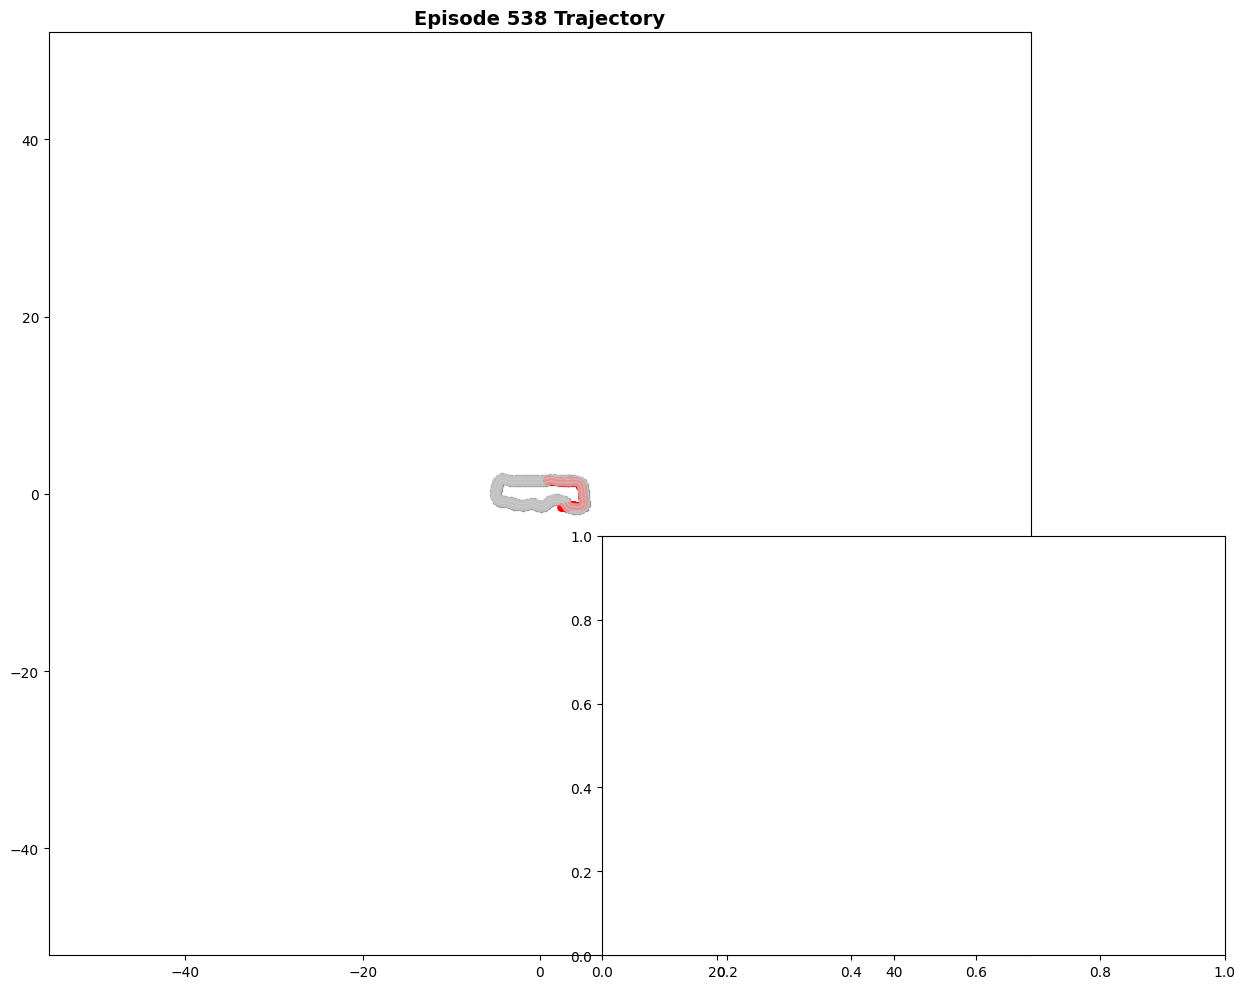

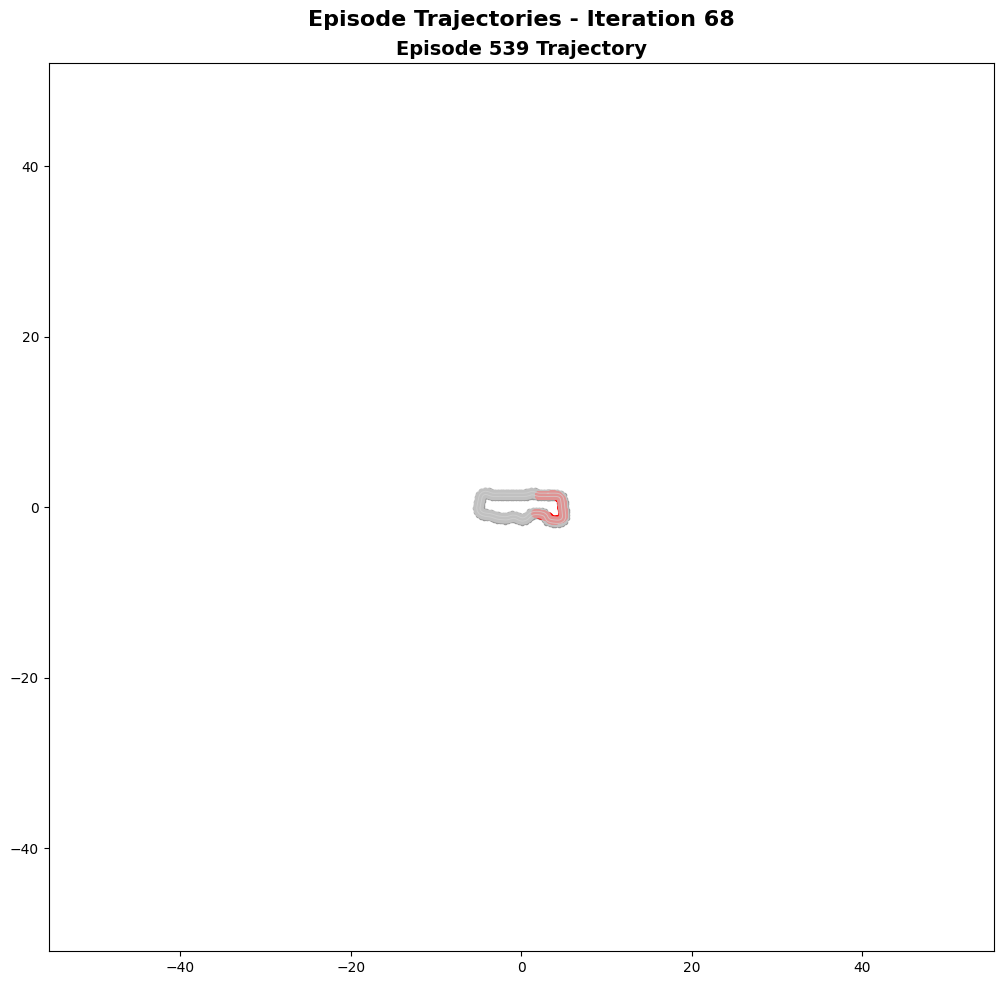

✓ Displayed 4 episode trajectories


In [36]:
print(f"Plotting episode trajectories for iteration {selected_iteration}...")

start_episode = (selected_iteration - 1) * EPISODES_PER_ITERATION
end_episode = selected_iteration * EPISODES_PER_ITERATION

episodes_to_plot = range(start_episode, min(end_episode, df['episode'].max() + 1))
num_episodes = len(episodes_to_plot)

if num_episodes > 0:
    episodes_sample = list(episodes_to_plot)[:4]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for i, episode_num in enumerate(episodes_sample):
        episode_data = df[df['episode'] == episode_num]
        if len(episode_data) > 0:
            plt.subplot(2, 2, i + 1)
            plot_episode_trajectory(episode_data, episode_num, style='red')
    
    plt.suptitle(f'Episode Trajectories - Iteration {selected_iteration}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Displayed {len(episodes_sample)} episode trajectories")
else:
    print("❌ No episodes found for the selected iteration")

Analyzing action patterns for iteration 68...


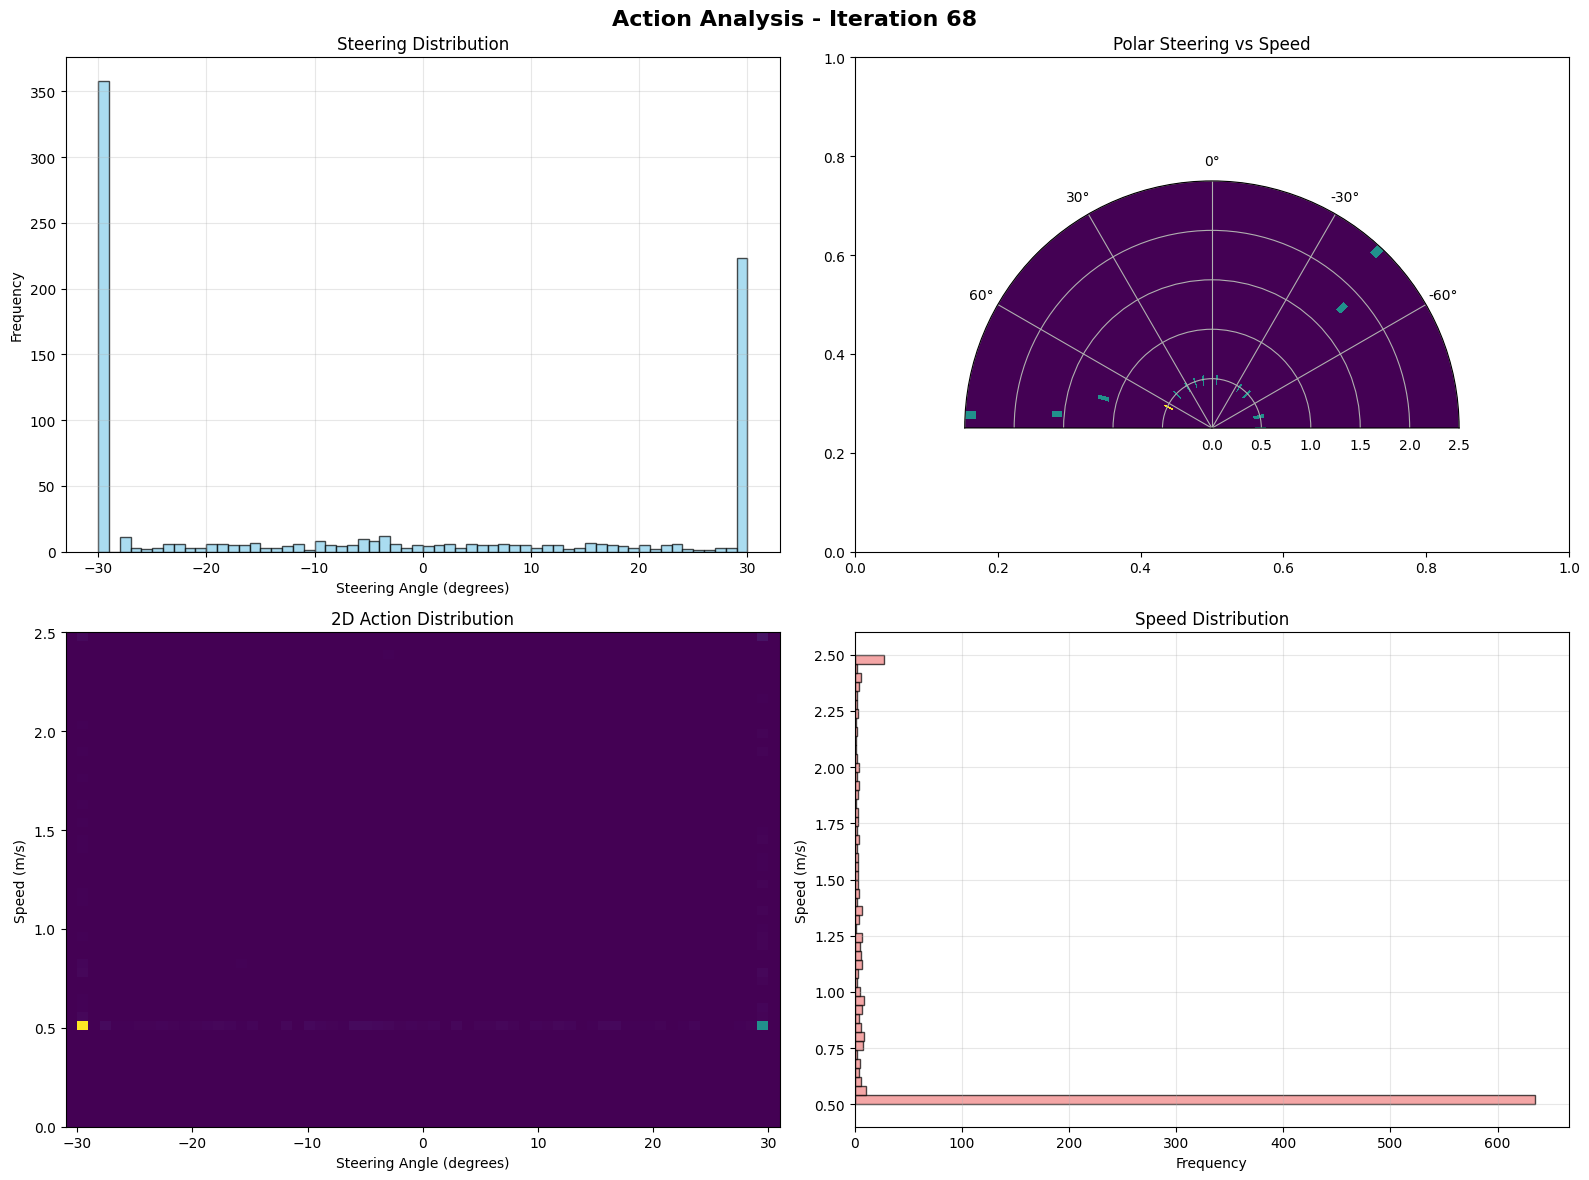

Iteration 68 statistics:
- Total steps: 851
- Episodes: 8
- Avg steering: -5.21°
- Avg speed: 0.74 m/s


In [37]:
# Generate histograms for selected iteration
if 'iteration' in df.columns:
    iteration_data = df[df['iteration'] == selected_iteration]
    
    if len(iteration_data) > 0:
        print(f"Analyzing action patterns for iteration {selected_iteration}...")
        
        plot_combined_histograms(iteration_data, f"- Iteration {selected_iteration}")
        plt.show()
        
        print(f"Iteration {selected_iteration} statistics:")
        print(f"- Total steps: {len(iteration_data)}")
        print(f"- Episodes: {iteration_data['episode'].nunique()}")
        print(f"- Avg steering: {iteration_data['steering_angle'].mean() * angle_normalization:.2f}°")
        print(f"- Avg speed: {iteration_data['speed'].mean():.2f} m/s")
    else:
        print(f"❌ No data found for iteration {selected_iteration}")
else:
    print("⚠️  Iteration data not available in this dataset")

In [38]:
if 'episode' in df.columns:
    available_episodes = sorted(df['episode'].unique())
    
    # Use the first complete episode or a mid-range episode
    selected_episode = available_episodes[min(len(available_episodes) // 2, 5)]
    
    print(f"Available episodes: {min(available_episodes)} to {max(available_episodes)} "
          f"(Total: {len(available_episodes)})")
    print(f"Analyzing episode: {selected_episode}")
else:
    selected_episode = 1
    print("Using default episode value")

Available episodes: 0 to 591 (Total: 592)
Analyzing episode: 5




# Analyzing specific episode



Episode 5 statistics:
- Total steps: 23
- Track completion: 6.8%
- Average speed: 1.63 m/s


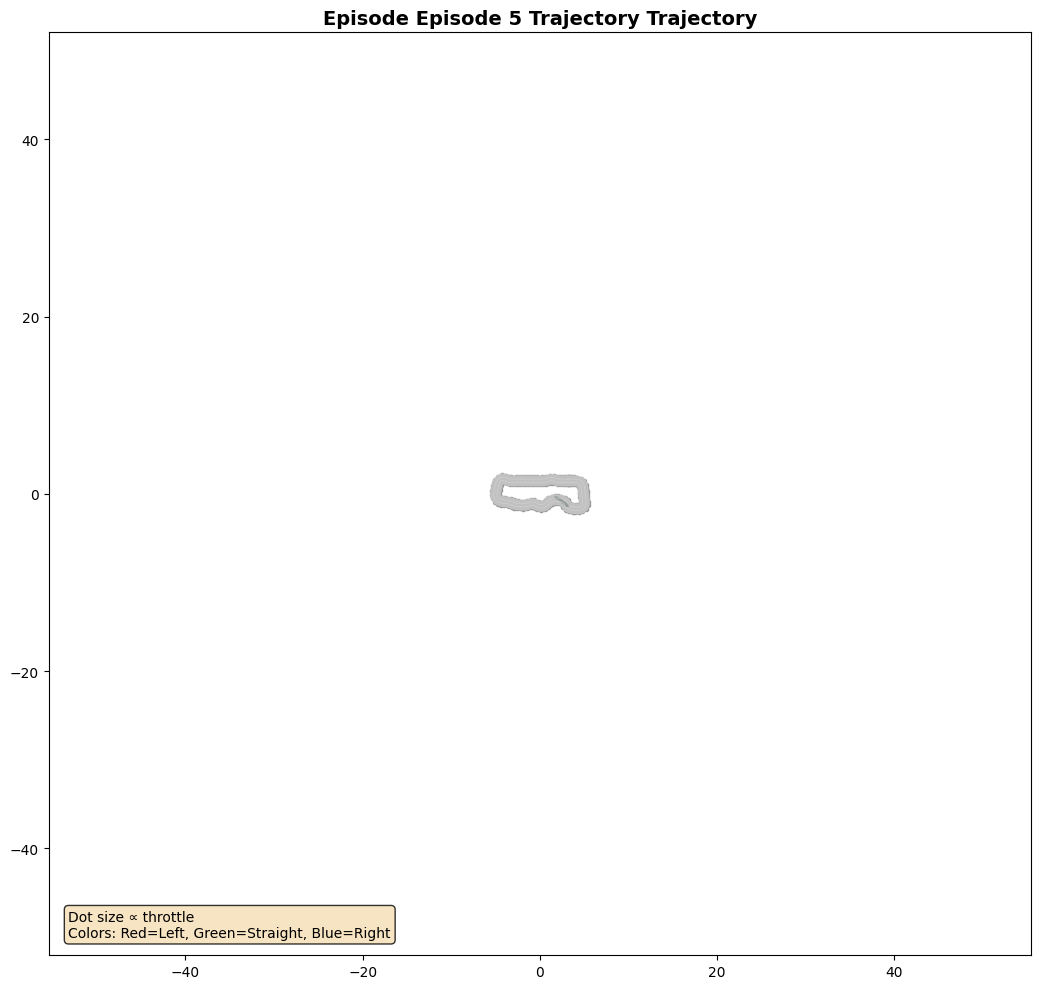

In [39]:
if 'episode' in df.columns:
    episode_data = df[df['episode'] == selected_episode]
    
    if len(episode_data) > 0:
        print(f"Episode {selected_episode} statistics:")
        print(f"- Total steps: {len(episode_data)}")
        print(f"- Track completion: {episode_data['progress'].max():.1f}%")
        print(f"- Average speed: {episode_data['speed'].mean():.2f} m/s")
        
        plot_episode_trajectory(episode_data, f"Episode {selected_episode} Trajectory")
        plt.show()
    else:
        print(f"❌ No data found for episode {selected_episode}")
else:
    print("⚠️  Episode data not available in this dataset")

Analyzing action patterns for episode 5...


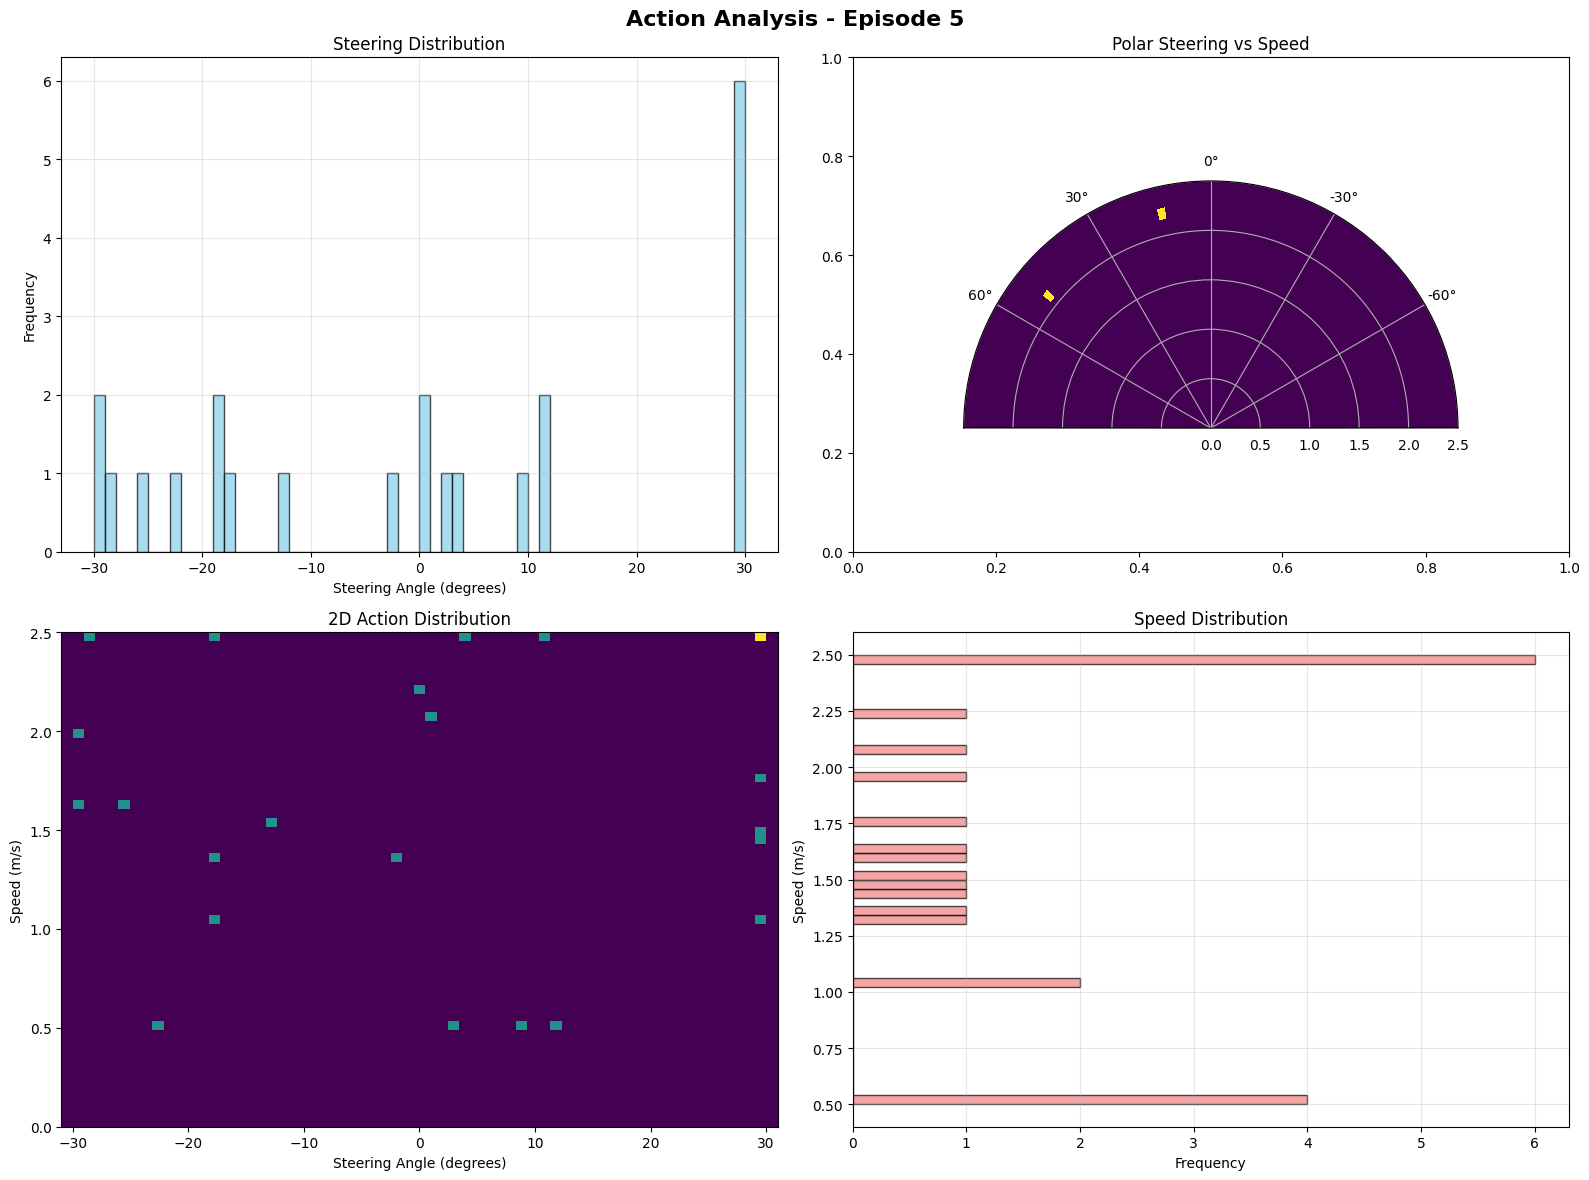

Episode 5 action analysis:
- Most used action: -1 (23 times)


NameError: name 'total_actions' is not defined

In [40]:
if 'episode' in df.columns:
    episode_data = df[df['episode'] == selected_episode]
    
    if len(episode_data) > 0:
        print(f"Analyzing action patterns for episode {selected_episode}...")
        
        plot_combined_histograms(episode_data, f"- Episode {selected_episode}")
        plt.show()
        
        # Action distribution statistics
        action_counts = episode_data['action'].value_counts().sort_index()
        most_used_action = action_counts.idxmax()
        
        print(f"Episode {selected_episode} action analysis:")
        print(f"- Most used action: {most_used_action} ({action_counts[most_used_action]} times)")
        print(f"- Unique actions used: {len(action_counts)}/{total_actions}")
        print(f"- Action diversity: {len(action_counts)/total_actions:.1%}")
    else:
        print(f"❌ No data found for episode {selected_episode}")
else:
    print("⚠️  Episode data not available in this dataset")

In [ ]:
selected_action = 5

print(f"Detailed Analysis: Action {selected_action}")
print("=" * 40)

if selected_action < len(action_space_list):
    action_item = action_space_list[selected_action]
    
    print(f"Action Properties:")
    print(f"- Index: {action_item.index}")
    print(f"- Steering: {action_item.steering_angle:.1f}°")
    print(f"- Speed: {action_item.speed:.2f} m/s")
    print(f"- Throttle: {action_item.relative_throttle:.2f}")
    
    # Filter dataframe for this specific action
    action_data = df[df['action'] == selected_action]
    
    if len(action_data) > 0:
        print(f"\nUsage Statistics:")
        print(f"- Times used: {len(action_data)}")
        print(f"- Usage frequency: {len(action_data)/len(df):.1%}")
        print(f"- Avg progress when used: {action_data['progress'].mean():.1f}%")
        
        if 'episode' in df.columns:
            episodes_used = action_data['episode'].nunique()
            print(f"- Episodes featuring this action: {episodes_used}")
    else:
        print(f"\n⚠️  Action {selected_action} was never used in this dataset")
else:
    print(f"❌ Action {selected_action} not found in action space")

Detailed Analysis: Action 5
❌ Action 5 not found in action space


Analyzing action usage patterns...


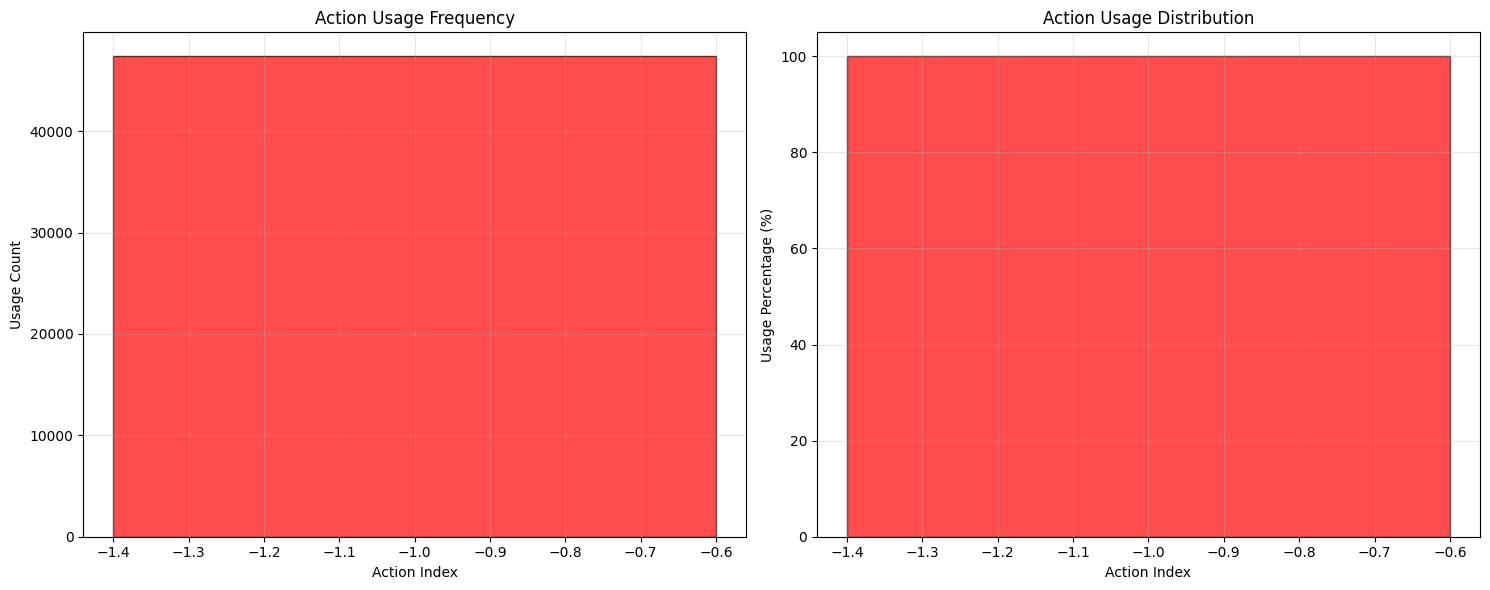


Action Usage Summary:
- Most used action: -1 (47376 times, 100.0%)
- Least used action: -1 (47376 times, 100.0%)


NameError: name 'total_actions' is not defined

In [42]:
# Compare action usage patterns
print("Analyzing action usage patterns...")

# Calculate action usage statistics
action_usage_stats = df['action'].value_counts().sort_index()
total_steps = len(df)

# Create visualization of action usage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of action usage counts
ax1.bar(action_usage_stats.index, action_usage_stats.values, 
        color=['red' if i < len(action_space_list) and action_space_list[i].steering_angle < -5 
               else 'blue' if i < len(action_space_list) and action_space_list[i].steering_angle > 5 
               else 'green' for i in action_usage_stats.index],
        alpha=0.7, edgecolor='black')

ax1.set_xlabel('Action Index')
ax1.set_ylabel('Usage Count')
ax1.set_title('Action Usage Frequency')
ax1.grid(True, alpha=0.3)

# Percentage usage
action_percentages = action_usage_stats / total_steps * 100
ax2.bar(action_percentages.index, action_percentages.values,
        color=['red' if i < len(action_space_list) and action_space_list[i].steering_angle < -5 
               else 'blue' if i < len(action_space_list) and action_space_list[i].steering_angle > 5 
               else 'green' for i in action_percentages.index],
        alpha=0.7, edgecolor='black')

ax2.set_xlabel('Action Index')
ax2.set_ylabel('Usage Percentage (%)')
ax2.set_title('Action Usage Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print usage statistics
print(f"\nAction Usage Summary:")
print(f"- Most used action: {action_usage_stats.idxmax()} ({action_usage_stats.max()} times, {action_usage_stats.max()/total_steps:.1%})")
print(f"- Least used action: {action_usage_stats.idxmin()} ({action_usage_stats.min()} times, {action_usage_stats.min()/total_steps:.1%})")
print(f"- Actions never used: {total_actions - len(action_usage_stats)}")
print(f"- Total unique actions used: {len(action_usage_stats)}/{total_actions}")

Analyzing steering behavior patterns...
Steering Direction Analysis:
- Left turns (1 actions): 47376 steps (100.0%)
- Straight (0 actions): 0 steps (0.0%)
- Right turns (0 actions): 0 steps (0.0%)


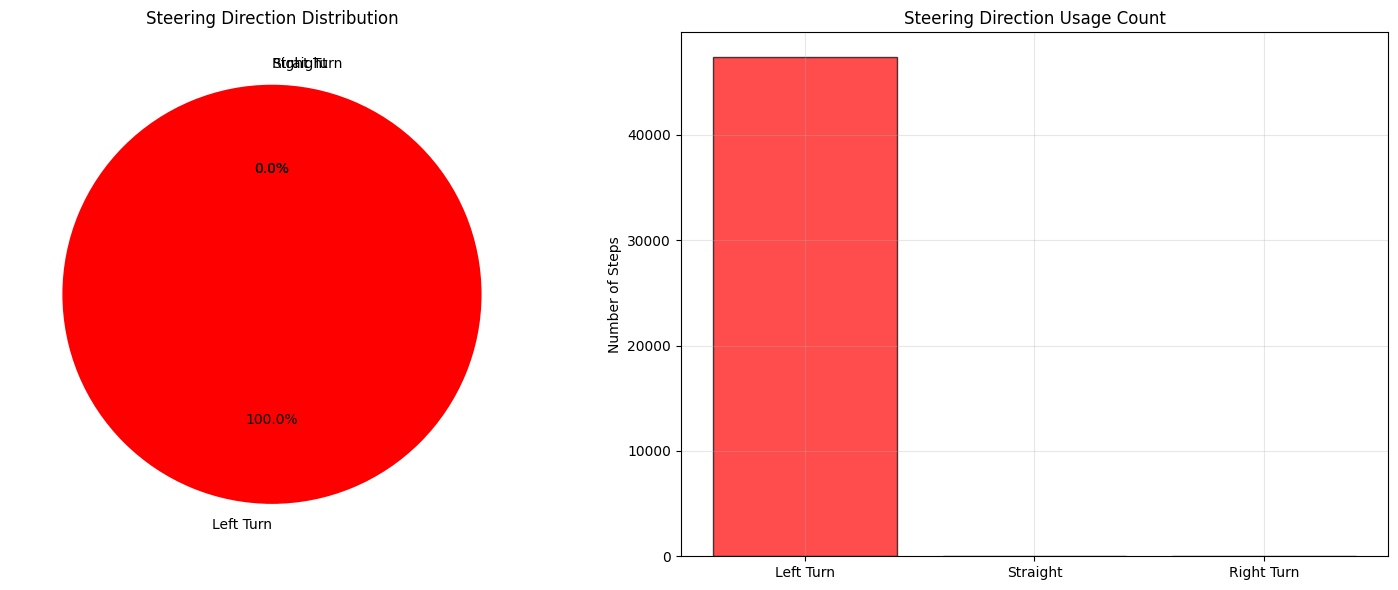


Speed Analysis by Direction:
- Average speed for left turns: 0.50 m/s


In [43]:
# Analyze steering behavior patterns
print("Analyzing steering behavior patterns...")

# Categorize actions by steering direction
left_actions = [a for a in action_space_list if a.steering_angle < -5]
straight_actions = [a for a in action_space_list if -5 <= a.steering_angle <= 5]
right_actions = [a for a in action_space_list if a.steering_angle > 5]

# Calculate usage for each category
left_usage = sum(action_usage_stats.get(a.index, 0) for a in left_actions)
straight_usage = sum(action_usage_stats.get(a.index, 0) for a in straight_actions)
right_usage = sum(action_usage_stats.get(a.index, 0) for a in right_actions)

total_categorized = left_usage + straight_usage + right_usage

print(f"Steering Direction Analysis:")
print(f"- Left turns ({len(left_actions)} actions): {left_usage} steps ({left_usage/total_categorized:.1%})")
print(f"- Straight ({len(straight_actions)} actions): {straight_usage} steps ({straight_usage/total_categorized:.1%})")
print(f"- Right turns ({len(right_actions)} actions): {right_usage} steps ({right_usage/total_categorized:.1%})")

# Visualize steering direction preferences
labels = ['Left Turn', 'Straight', 'Right Turn']
sizes = [left_usage, straight_usage, right_usage]
colors = ['red', 'green', 'blue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Steering Direction Distribution')

# Bar chart
ax2.bar(labels, sizes, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of Steps')
ax2.set_title('Steering Direction Usage Count')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Speed analysis by steering direction
if len(left_actions) > 0:
    avg_left_speed = np.mean([a.speed for a in left_actions])
    print(f"\nSpeed Analysis by Direction:")
    print(f"- Average speed for left turns: {avg_left_speed:.2f} m/s")

if len(straight_actions) > 0:
    avg_straight_speed = np.mean([a.speed for a in straight_actions])
    print(f"- Average speed for straight: {avg_straight_speed:.2f} m/s")

if len(right_actions) > 0:
    avg_right_speed = np.mean([a.speed for a in right_actions])
    print(f"- Average speed for right turns: {avg_right_speed:.2f} m/s")

Creating action usage heatmap...


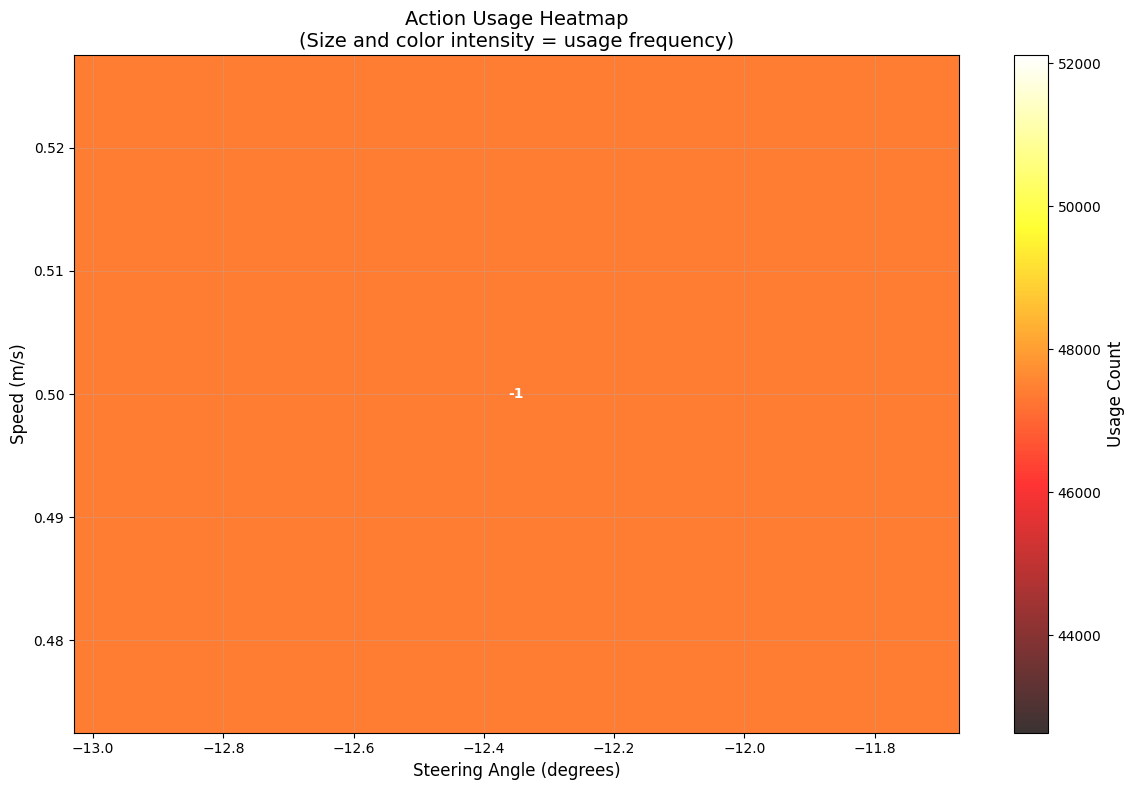

Heatmap shows 1 actions with recorded usage


In [44]:
# Create heatmap visualization of action usage
print("Creating action usage heatmap...")

# Prepare data for heatmap
steering_angles = [a.steering_angle for a in action_space_list]
speeds = [a.speed for a in action_space_list]
usage_counts = [action_usage_stats.get(a.index, 0) for a in action_space_list]

# Create scatter plot with size and color representing usage
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    steering_angles, 
    speeds,
    c=usage_counts,
    s=[u * 100 + 50 for u in usage_counts],  # Size proportional to usage
    cmap='hot',
    alpha=0.8,
    edgecolors='black',
    linewidth=1
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Usage Count', fontsize=12)

# Add action indices as labels
for i, action in enumerate(action_space_list):
    if usage_counts[i] > 0:  # Only label used actions
        ax.annotate(
            str(action.index),
            (action.steering_angle, action.speed),
            ha='center', va='center',
            fontsize=10, fontweight='bold',
            color='white' if usage_counts[i] > max(usage_counts) * 0.5 else 'black'
        )

ax.set_xlabel('Steering Angle (degrees)', fontsize=12)
ax.set_ylabel('Speed (m/s)', fontsize=12)
ax.set_title('Action Usage Heatmap\n(Size and color intensity = usage frequency)', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Heatmap shows {len([u for u in usage_counts if u > 0])} actions with recorded usage")

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions

In [45]:
# Comprehensive Analysis Summary
print("=" * 60)
print("DEEPRACER ACTION SPACE ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n🏁 TRACK INFORMATION:")
print(f"   Track: {track_name}")
print(f"   Direction: {track_direction}")
print(f"   Total waypoints: {len(waypoints)}")

print(f"\n🎯 ACTION SPACE METRICS:")
print(f"   Total discrete actions: {total_actions}")
print(f"   Steering range: {action_bounds['steering_min']}° to {action_bounds['steering_max']}°")
print(f"   Speed range: {action_bounds['speed_min']} to {action_bounds['speed_max']} m/s")

print(f"\n📊 USAGE STATISTICS:")
print(f"   Total training steps: {total_steps:,}")
print(f"   Actions actually used: {len(action_usage_stats)}/{total_actions} ({len(action_usage_stats)/total_actions:.1%})")
print(f"   Unused actions: {total_actions - len(action_usage_stats)}")

if 'episode' in df.columns:
    print(f"   Episodes analyzed: {df['episode'].nunique()}")
    print(f"   Average steps per episode: {len(df) / df['episode'].nunique():.1f}")

if 'iteration' in df.columns:
    print(f"   Training iterations: {df['iteration'].nunique()}")

print(f"\n🚗 BEHAVIOR PATTERNS:")
print(f"   Most used action: #{action_usage_stats.idxmax()} ({action_usage_stats.max():,} times)")
print(f"   Action diversity index: {len(action_usage_stats)/total_actions:.1%}")

# Steering preference analysis
if total_categorized > 0:
    print(f"   Left turn preference: {left_usage/total_categorized:.1%}")
    print(f"   Straight driving: {straight_usage/total_categorized:.1%}")
    print(f"   Right turn preference: {right_usage/total_categorized:.1%}")

print(f"\n💡 KEY INSIGHTS:")
if len(action_usage_stats) < total_actions * 0.5:
    print(f"   ⚠️  Low action diversity - only {len(action_usage_stats)/total_actions:.1%} of available actions used")
else:
    print(f"   ✓ Good action diversity - {len(action_usage_stats)/total_actions:.1%} of actions utilized")

# Check for steering bias
if total_categorized > 0:
    max_direction = max(left_usage, straight_usage, right_usage)
    if max_direction > total_categorized * 0.6:
        if max_direction == left_usage:
            print(f"   📈 Strong left turn bias detected ({left_usage/total_categorized:.1%})")
        elif max_direction == right_usage:
            print(f"   📈 Strong right turn bias detected ({right_usage/total_categorized:.1%})")
        else:
            print(f"   📈 Straight driving preference ({straight_usage/total_categorized:.1%})")
    else:
        print(f"   ✓ Balanced steering behavior across directions")

print(f"\n" + "=" * 60)

DEEPRACER ACTION SPACE ANALYSIS SUMMARY

🏁 TRACK INFORMATION:
   Track: thunder_hill_pro_cw.npy


NameError: name 'track_direction' is not defined

In [ ]:
# Analysis complete
print("✅ Action Space Analysis Complete!")
print("\nNext steps for optimization:")
print("• Review unused actions - consider pruning action space")
print("• Analyze action sequences for pattern optimization")  
print("• Compare performance metrics across different action categories")
print("• Consider reward function adjustments based on steering bias")

# Export summary for further analysis
analysis_summary = {
    'track_name': track_name,
    'total_actions': total_actions,
    'actions_used': len(action_usage_stats),
    'action_diversity': len(action_usage_stats) / total_actions,
    'total_steps': total_steps,
    'most_used_action': int(action_usage_stats.idxmax()),
    'steering_bias': {
        'left_percentage': left_usage / total_categorized if total_categorized > 0 else 0,
        'straight_percentage': straight_usage / total_categorized if total_categorized > 0 else 0,
        'right_percentage': right_usage / total_categorized if total_categorized > 0 else 0
    }
}

print(f"\n📋 Analysis summary saved to 'analysis_summary' variable")
print("Use this data for comparative studies across different training runs")